# START

In [5]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy import signal

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

#simple forecasting
from statsforecast.models import HistoricAverage
from statsforecast.models import Naive
from statsforecast.models import SeasonalNaive
from statsforecast.models import RandomWalkWithDrift

#ARIMA SARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PROJECT STEPS

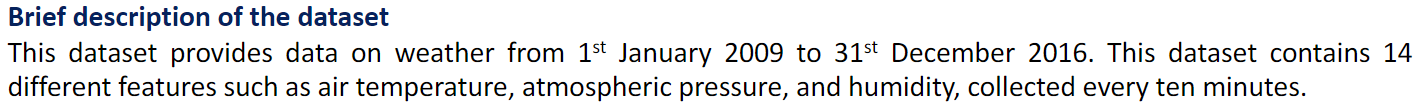

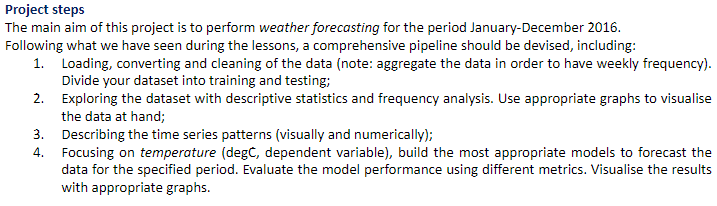

## Box-Jenkins method
When dealing with the family of ARIMA models, it is important to remember the **Box-Jenkins methodology** proposed by George Box and Gwilym Jenkins in their seminal book entitled *Time Series Analysis: Forecasting and Control* (1970) to find the best model. This refers to a systematic method of identifying, fitting, checking, and using ARIMA models built for time series forecasting. The approach starts with the assumption that the process that generated the time series can be approximated using a model from the ARIMA family. Starting from the available time series and use separate train/test sets, the process includes the following steps:

**1.   Model Identification:** as first step, it is important to verify the stationarity, determine if our time series is seasonal and find the seasonal period, and eventually apply appropriate transformations to reduce the variance (e.g., logarithm). When data have a strong seasonal pattern, seasonal differencing should be used as first step. Once stationarity and seasonality have been addressed, the next step is to identify the order (p,d,q) of ARIMA models in order to capture the salient dynamic features
of the data. This is usually done by relying on ACF/PACF plots or on grid search;

**2.   Model estimation:**  Once the model order has been identified, the model parameter are estimated generally using maximum likelihood estimation. Appropriate criteria, such as AIC, AICc and BIC, have to be used to compare and select the best model;

**3.   Model diagnostic:** After fitting the model on the train data, conduct goodness-of-fit checks to ensure the model describes the data adequately. In particular the residuals are taken and it is assessed whether they are white noise and they are normally distributed. ACF plot of the residuals can help in this respect, along with statistical tests as the Ljung-Box test.
If the assumed model is appropriate for the data, the residuals should satisfy these assumptions. If they are not satisfied, we have to go back to the model identification step and try to develop a better model;

**4.   Forecasting:** If the model is good, we can finally perform the forecasting analyses in the separate test set, and perform all the performance evalutations (e.g., MAE, MSE/RMSE, MAPE, R2).


# LOADING CONVERTING AND CLEANING OF THE DATA

## Load

In [6]:
Weather_data = pd.read_csv('Weather_ts.csv', sep=',', parse_dates=['Date Time'], date_format={'Date Time': '%d.%m.%Y %H:%M:%S'}, index_col='Date Time')
#with only the parser the data will not be datatime
#to resolve this problem i use the date_format
display(Weather_data.head(10))

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
2009-01-01 00:50:00    996.51     -8.27    265.15        -9.04    94.1   
2009-01-01 01:00:00    996.50     -8.05    265.38        -8.78    94.4   
2009-01-01 01:10:00    996.50     -7.62    265.81        -8.30    94.8   
2009-01-01 01:20:00    996.50     -7.62    265.81        -8.36    94.4   
2009-01-01 01:30:00    996.50     -7.91    265.52        -8.73    93.8   
2009-01-01 01:40:00    996.53     -8.43    264.99        -9.34    93.1   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   
2009-01-01 00:30:00          3.21          3.01          0.20       1.88   
2009-01-01 00:40:00          3.26          3.07          0.19       1.92   
2009-01-01 00:50:00          3.27          3.08          0.19       1.92   
2009-01-01 01:00:00          3.33          3.14          0.19       1.96   
2009-01-01 01:10:00          3.44          3.26          0.18       2.04   
2009-01-01 01:20:00          3.44          3.25          0.19       2.03   
2009-01-01 01:30:00          3.36          3.15          0.21       1.97   
2009-01-01 01:40:00          3.23          3.00          0.22       1.88   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
2009-01-01 00:10:00             3.12       1307.75      1.03           1.75   
2009-01-01 00:20:00             3.03       1309.80      0.72           1.50   
2009-01-01 00:30:00             3.02       1310.24      0.19           0.63   
2009-01-01 00:40:00             3.08       1309.19      0.34           0.50   
2009-01-01 00:50:00             3.09       1309.00      0.32           0.63   
2009-01-01 01:00:00             3.15       1307.86      0.21           0.63   
2009-01-01 01:10:00             3.27       1305.68      0.18           0.63   
2009-01-01 01:20:00             3.26       1305.69      0.19           0.50   
2009-01-01 01:30:00             3.16       1307.17      0.28           0.75   
2009-01-01 01:40:00             3.02       1309.85      0.59           0.88   

                     wd (deg)  
Date Time                      
2009-01-01 00:10:00     152.3  
2009-01-01 00:20:00     136.1  
2009-01-01 00:30:00     171.6  
2009-01-01 00:40:00     198.0  
2009-01-01 00:50:00     214.3  
2009-01-01 01:00:00     192.7  
2009-01-01 01:10:00     166.5  
2009-01-01 01:20:00     118.6  
2009-01-01 01:30:00     188.5  
2009-01-01 01:40:00     185.0

Variables 

-   1	Date Time		Date-time reference (INDEX)
-   2	p (mbar)		Pressure used to quantify internal pressure (in millibars) 
-   3	T (degC)		Temperature in Celsius
-   4	Tpot (K)	             Temperature in Kelvin
-   5	Tdew (degC)		Temperature in Celsius relative to humidity 
-   6	rh (%)		             Relative Humidity 
-   7	VPmax (mbar)	Saturation vapor pressure
-   8	VPact (mbar)		Vapor pressure
-   9	VPdef (mbar)		Vapor pressure deficit
-   10	sh (g/kg)		Specific humidity
-   11	H2OC (mmol/mol)	Water vapor concentration
-   12	rho (g/m**3)	             Airtight 
-   13	wv (m/s)		Wind speed
-   14	max. wv (m/s)	Maximum wind speed
-   15	wd (deg)		Wind direction in degrees


## Clean

In [7]:
#info
Weather_data.info() #no null values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420550 entries, 2009-01-01 00:10:00 to 2016-12-31 23:50:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420550 non-null  float64
 1   T (degC)         420550 non-null  float64
 2   Tpot (K)         420550 non-null  float64
 3   Tdew (degC)      420550 non-null  float64
 4   rh (%)           420550 non-null  float64
 5   VPmax (mbar)     420550 non-null  float64
 6   VPact (mbar)     420550 non-null  float64
 7   VPdef (mbar)     420550 non-null  float64
 8   sh (g/kg)        420550 non-null  float64
 9   H2OC (mmol/mol)  420550 non-null  float64
 10  rho (g/m**3)     420550 non-null  float64
 11  wv (m/s)         420550 non-null  float64
 12  max. wv (m/s)    420550 non-null  float64
 13  wd (deg)         420550 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


In [8]:
#second test null value
Weather_data.isna().sum() #no null values

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [9]:
#columns
Weather_data.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [10]:
Weather_data.describe()

p (mbar)       T (degC)       Tpot (K)    Tdew (degC)  \
count  420550.000000  420550.000000  420550.000000  420550.000000   
mean      989.212751       9.450181     283.492779       4.955886   
std         8.358475       8.423346       8.504449       6.730651   
min       913.600000     -23.010000     250.600000     -25.010000   
25%       984.200000       3.360000     277.430000       0.240000   
50%       989.580000       9.420000     283.470000       5.220000   
75%       994.720000      15.470000     289.530000      10.070000   
max      1015.350000      37.280000     311.340000      23.110000   

              rh (%)   VPmax (mbar)   VPact (mbar)   VPdef (mbar)  \
count  420550.000000  420550.000000  420550.000000  420550.000000   
mean       76.008260      13.576273       9.533771       4.042419   
std        16.476195       7.739016       4.184158       4.896855   
min        12.950000       0.950000       0.790000       0.000000   
25%        65.210000       7.780000       6.210000       0.870000   
50%        79.300000      11.820000       8.860000       2.190000   
75%        89.400000      17.600000      12.350000       5.300000   
max       100.000000      63.770000      28.320000      46.010000   

           sh (g/kg)  H2OC (mmol/mol)   rho (g/m**3)       wv (m/s)  \
count  420550.000000    420550.000000  420550.000000  420550.000000   
mean        6.022418         9.640238    1216.062557       1.702225   
std         2.656135         4.235388      39.975064      65.446792   
min         0.500000         0.800000    1059.450000   -9999.000000   
25%         3.920000         6.290000    1187.490000       0.990000   
50%         5.590000         8.960000    1213.790000       1.760000   
75%         7.800000        12.490000    1242.770000       2.860000   
max        18.130000        28.820000    1393.540000      28.490000   

       max. wv (m/s)       wd (deg)  
count  420550.000000  420550.000000  
mean        3.056558     174.743714  
std        69.017014      86.681794  
min     -9999.000000       0.000000  
25%         1.760000     124.900000  
50%         2.960000     198.100000  
75%         4.740000     234.100000  
max        23.500000     360.000000

## Convert

we wnat to have weekly frequency

In [11]:
Weather_data.index

DatetimeIndex(['2009-01-01 00:10:00', '2009-01-01 00:20:00',
               '2009-01-01 00:30:00', '2009-01-01 00:40:00',
               '2009-01-01 00:50:00', '2009-01-01 01:00:00',
               '2009-01-01 01:10:00', '2009-01-01 01:20:00',
               '2009-01-01 01:30:00', '2009-01-01 01:40:00',
               ...
               '2016-12-31 22:20:00', '2016-12-31 22:30:00',
               '2016-12-31 22:40:00', '2016-12-31 22:50:00',
               '2016-12-31 23:00:00', '2016-12-31 23:10:00',
               '2016-12-31 23:20:00', '2016-12-31 23:30:00',
               '2016-12-31 23:40:00', '2016-12-31 23:50:00'],
              dtype='datetime64[ns]', name='Date Time', length=420550, freq=None)

In [12]:
Weather_data.index.year.unique()

Index([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], dtype='int32', name='Date Time')

In [13]:
Weather_data.index.month.unique()

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int32', name='Date Time')

In [14]:
Weather_data.index.day.unique()

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype='int32', name='Date Time')

In [15]:
Weather_data.index.minute.unique()

Index([10, 20, 30, 40, 50, 0], dtype='int32', name='Date Time')

In [16]:
Weather_data.index.second.unique()

Index([0], dtype='int32', name='Date Time')

In [17]:
#convert the data time in weekly frequency
Weather_data_wk = Weather_data.resample('W').mean()
display(Weather_data_wk)

p (mbar)   T (degC)    Tpot (K)  Tdew (degC)     rh (%)  \
Date Time                                                                
2009-01-04   996.446696  -4.292070  269.146087    -6.185148  87.255409   
2009-01-11   999.146161 -11.057847  262.168393   -13.171438  84.714841   
2009-01-18   991.308760  -1.717867  272.126657    -4.664692  81.310595   
2009-01-25   970.486319   1.151438  276.681220    -1.678264  82.035218   
2009-02-01   990.295337  -2.464573  271.454127    -3.848323  90.406944   
...                 ...        ...         ...          ...        ...   
2016-12-04   999.956121  -0.467679  272.701944    -3.387222  81.552579   
2016-12-11  1000.134891   1.667212  274.823413    -1.334246  81.225665   
2016-12-18  1002.300288   2.645923  275.628373     1.012192  89.163800   
2016-12-25  1000.907817   1.969593  275.060228    -0.343909  85.042927   
2017-01-01  1007.889549   2.689560  275.233866    -0.238472  81.632986   

            VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                         
2009-01-04      4.511496      3.918348      0.593009   2.451287   
2009-01-11      2.831081      2.369058      0.462044   1.477421   
2009-01-18      5.561796      4.483313      1.078720   2.820536   
2009-01-25      6.752004      5.444335      1.307619   3.499306   
2009-02-01      5.104276      4.617619      0.486429   2.905952   
...                  ...           ...           ...        ...   
2016-12-04      6.156409      4.900109      1.256071   3.058046   
2016-12-11      7.381587      5.828373      1.553492   3.637927   
2016-12-18      7.507450      6.704841      0.802490   4.174643   
2016-12-25      7.248353      6.080327      1.168135   3.788710   
2017-01-01      7.702361      6.203750      1.498484   3.838715   

            H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)    wd (deg)  
Date Time                                                                       
2009-01-04         3.934887   1289.293165  1.293252       2.310504  177.589652  
2009-01-11         2.372718   1327.335734  1.312153       2.256984  158.967391  
2009-01-18         4.526012   1270.352133  1.879524       2.970417  178.882599  
2009-01-25         5.613720   1230.040417  2.553998       3.973105  188.601022  
2009-02-01         4.663750   1272.179296  1.981885       3.170645   46.615129  
...                     ...           ...       ...            ...         ...  
2016-12-04         4.906677   1275.453720  1.437123       2.741706  190.730853  
2016-12-11         5.834554   1265.589107  1.437609       2.601359  182.925089  
2016-12-18         6.694365   1262.940823  1.418085       2.399752  185.361032  
2016-12-25         6.076379   1264.651042  1.912788       3.262143  184.388889  
2017-01-01         6.156250   1270.206458  1.972280       3.632130  222.820949  

[418 rows x 14 columns]

## Divide dataset into training and testing

The main aim of this project is to perform weather forecasting for the period January-December 2016.

In [18]:
#train everything before january 2016
Weather_data_wk_train = Weather_data_wk[Weather_data_wk.index < '2016-01-01']
Weather_data_wk_test = Weather_data_wk[Weather_data_wk.index >= '2016-01-01']

display(Weather_data_wk_train.index.year.unique())
display(Weather_data_wk_test.index.year.unique())

Index([2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype='int32', name='Date Time')

Index([2016, 2017], dtype='int32', name='Date Time')

# EXPLORING THE DATASET

## Descriptive Statistic

fare .describe e fare gli histogrammi

In [19]:
display(Weather_data_wk)

p (mbar)   T (degC)    Tpot (K)  Tdew (degC)     rh (%)  \
Date Time                                                                
2009-01-04   996.446696  -4.292070  269.146087    -6.185148  87.255409   
2009-01-11   999.146161 -11.057847  262.168393   -13.171438  84.714841   
2009-01-18   991.308760  -1.717867  272.126657    -4.664692  81.310595   
2009-01-25   970.486319   1.151438  276.681220    -1.678264  82.035218   
2009-02-01   990.295337  -2.464573  271.454127    -3.848323  90.406944   
...                 ...        ...         ...          ...        ...   
2016-12-04   999.956121  -0.467679  272.701944    -3.387222  81.552579   
2016-12-11  1000.134891   1.667212  274.823413    -1.334246  81.225665   
2016-12-18  1002.300288   2.645923  275.628373     1.012192  89.163800   
2016-12-25  1000.907817   1.969593  275.060228    -0.343909  85.042927   
2017-01-01  1007.889549   2.689560  275.233866    -0.238472  81.632986   

            VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                         
2009-01-04      4.511496      3.918348      0.593009   2.451287   
2009-01-11      2.831081      2.369058      0.462044   1.477421   
2009-01-18      5.561796      4.483313      1.078720   2.820536   
2009-01-25      6.752004      5.444335      1.307619   3.499306   
2009-02-01      5.104276      4.617619      0.486429   2.905952   
...                  ...           ...           ...        ...   
2016-12-04      6.156409      4.900109      1.256071   3.058046   
2016-12-11      7.381587      5.828373      1.553492   3.637927   
2016-12-18      7.507450      6.704841      0.802490   4.174643   
2016-12-25      7.248353      6.080327      1.168135   3.788710   
2017-01-01      7.702361      6.203750      1.498484   3.838715   

            H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)    wd (deg)  
Date Time                                                                       
2009-01-04         3.934887   1289.293165  1.293252       2.310504  177.589652  
2009-01-11         2.372718   1327.335734  1.312153       2.256984  158.967391  
2009-01-18         4.526012   1270.352133  1.879524       2.970417  178.882599  
2009-01-25         5.613720   1230.040417  2.553998       3.973105  188.601022  
2009-02-01         4.663750   1272.179296  1.981885       3.170645   46.615129  
...                     ...           ...       ...            ...         ...  
2016-12-04         4.906677   1275.453720  1.437123       2.741706  190.730853  
2016-12-11         5.834554   1265.589107  1.437609       2.601359  182.925089  
2016-12-18         6.694365   1262.940823  1.418085       2.399752  185.361032  
2016-12-25         6.076379   1264.651042  1.912788       3.262143  184.388889  
2017-01-01         6.156250   1270.206458  1.972280       3.632130  222.820949  

[418 rows x 14 columns]

### Plot

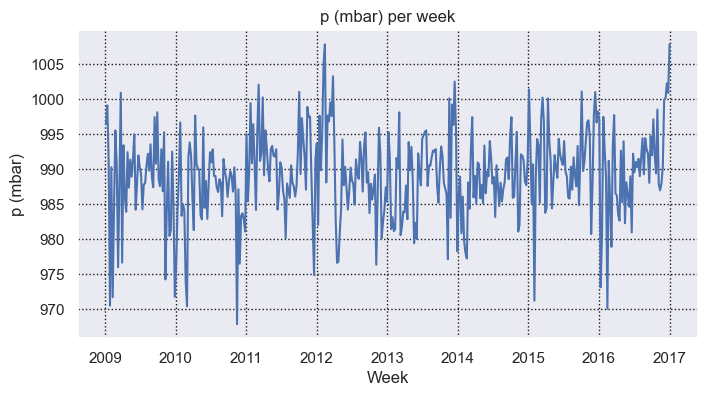

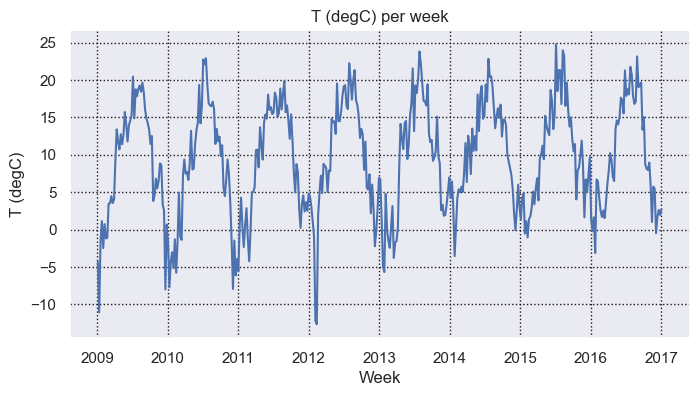

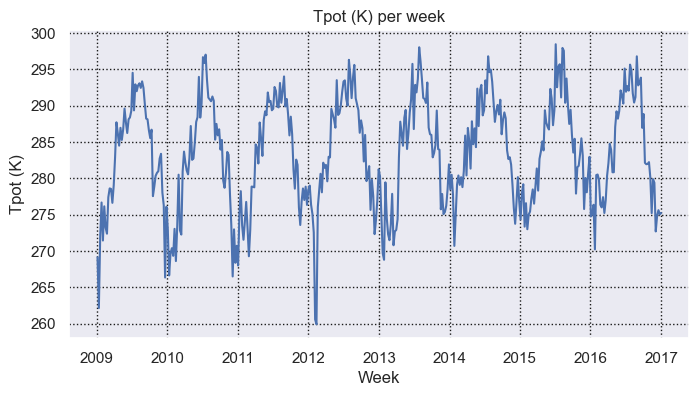

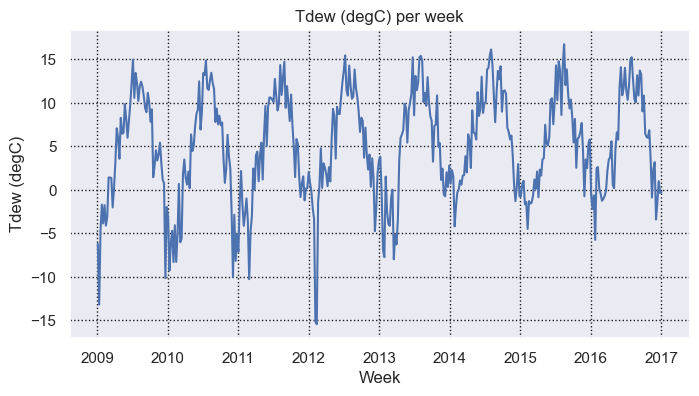

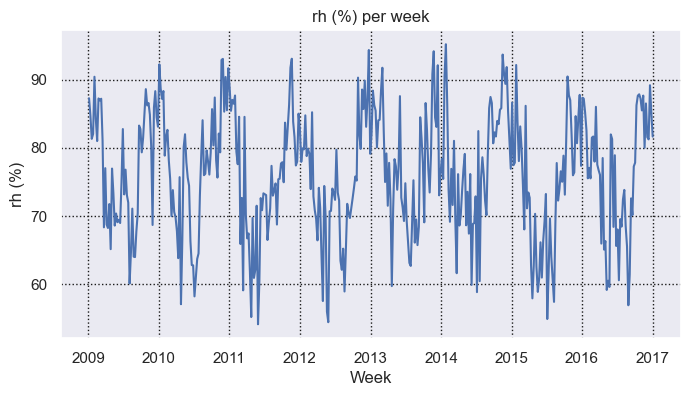

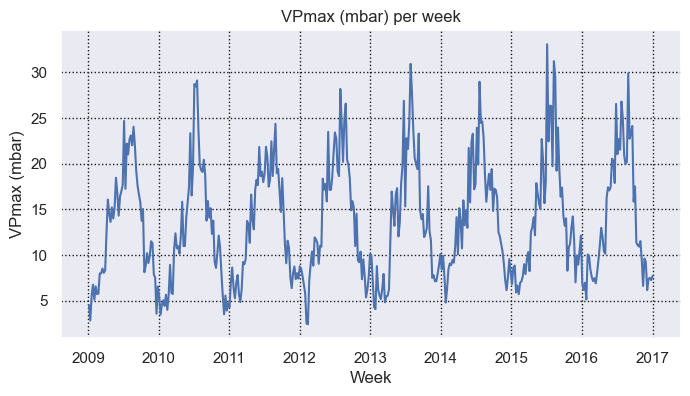

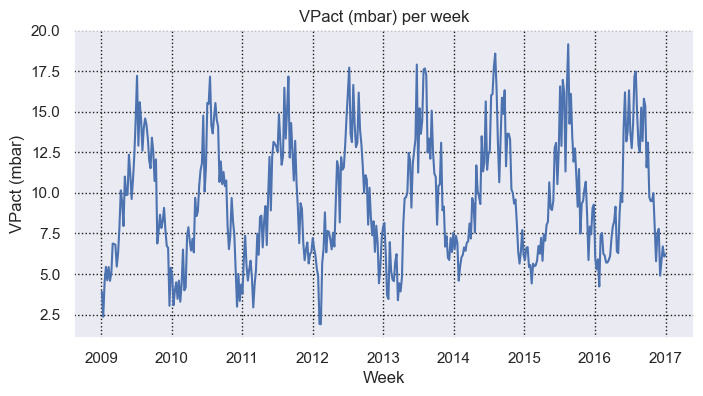

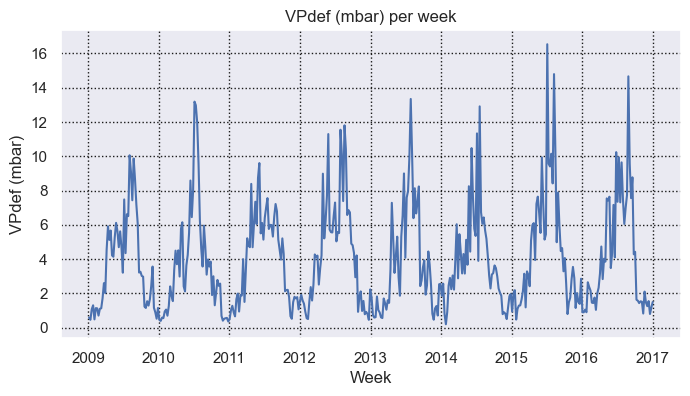

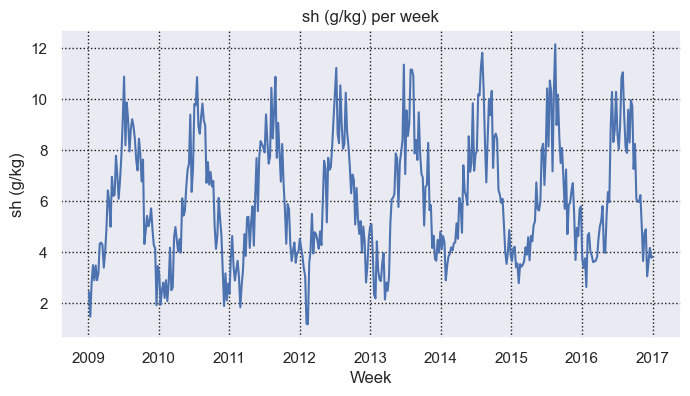

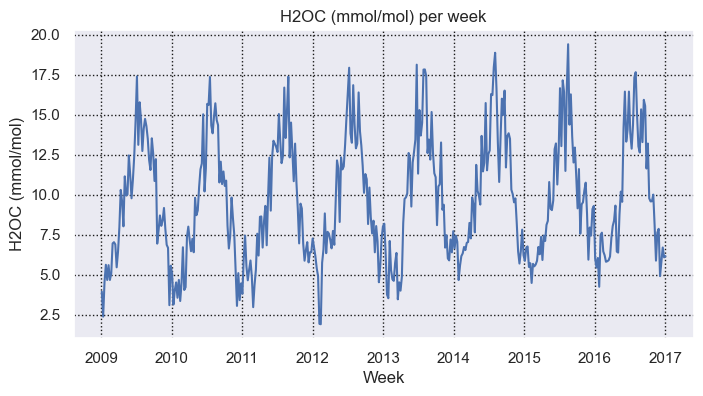

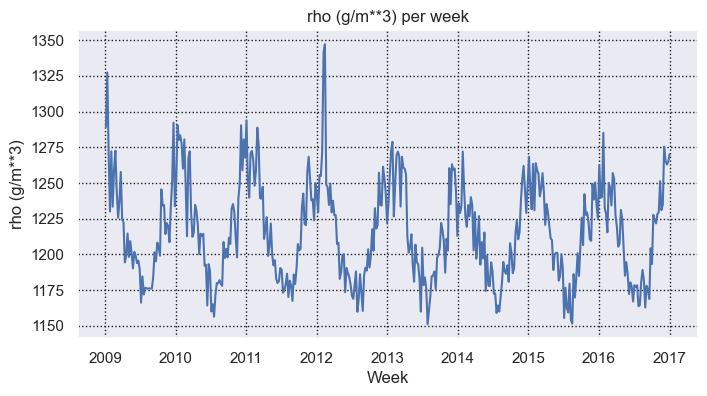

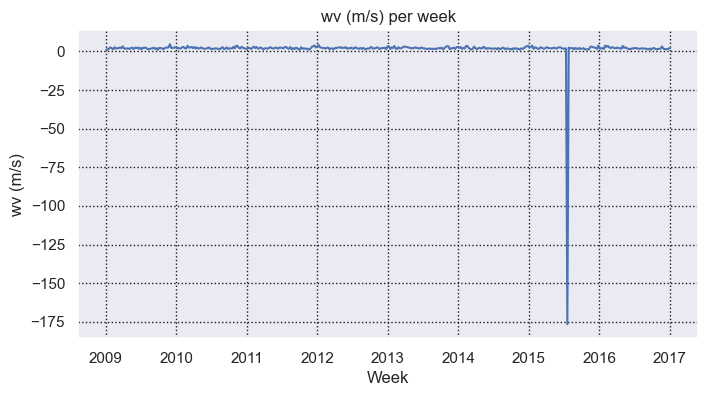

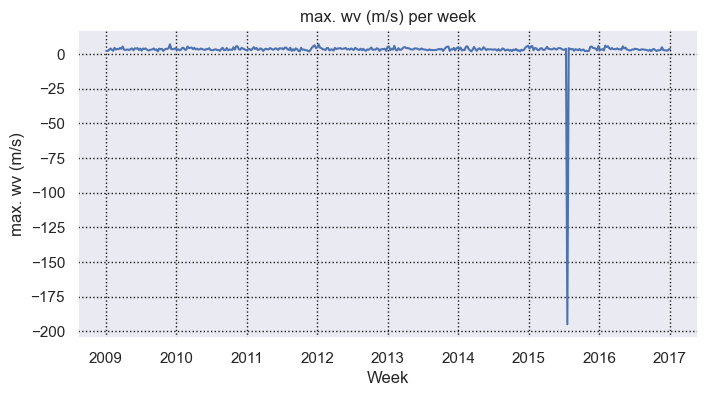

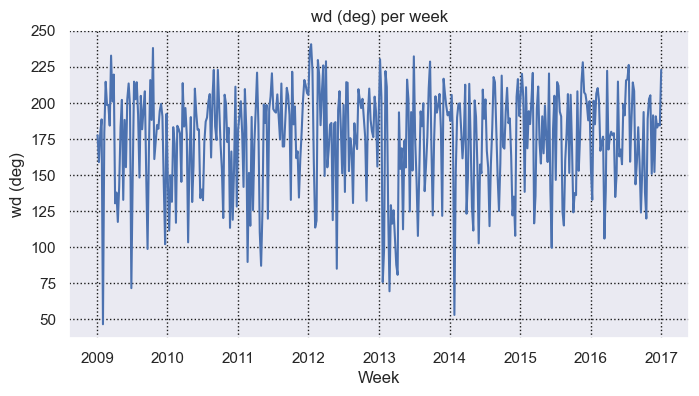

In [20]:
# plot all the data
for column in Weather_data_wk.columns:
    plt.figure(figsize=(8,4))
    plt.plot(Weather_data_wk[column])
    plt.grid(True, color = 'k', linestyle = ':')
    plt.title(column + ' per week')
    plt.xlabel('Week')
    plt.ylabel(column)

probabile outliers in max????? controllare

### Heatmap

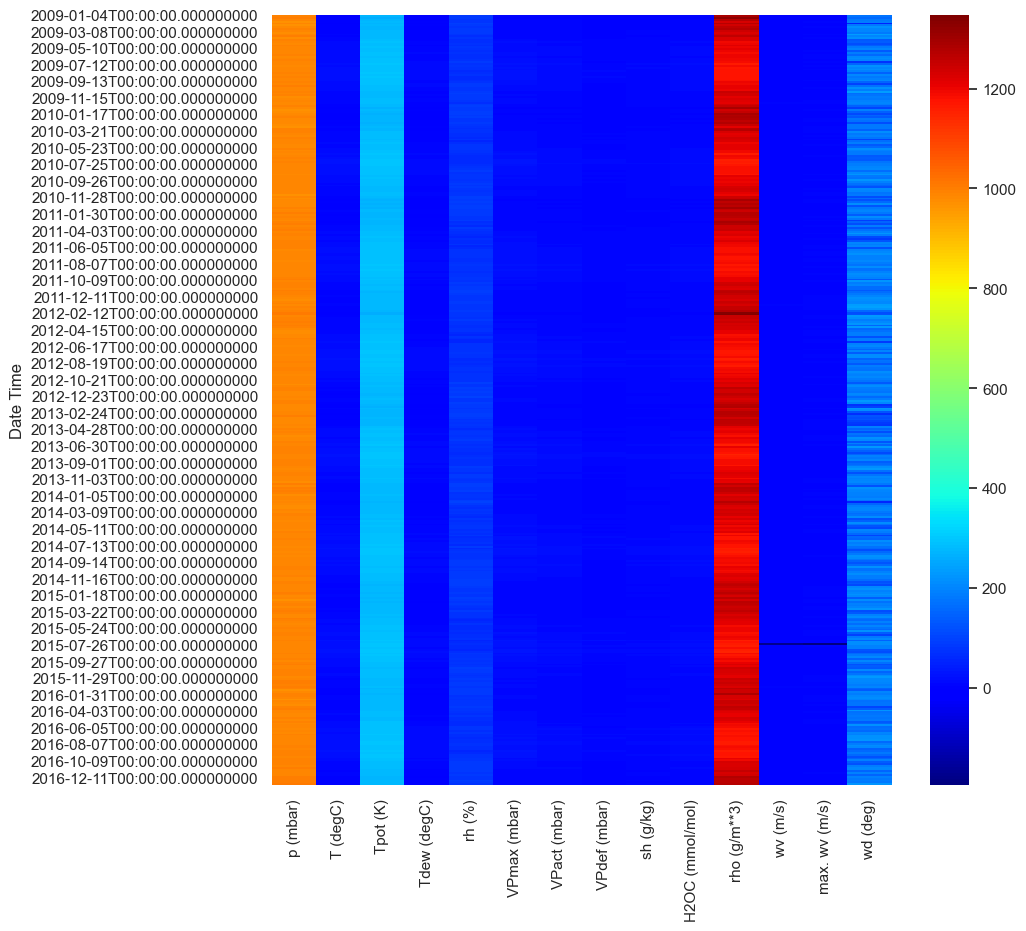

In [21]:
#heatmap
plt.figure(figsize=(10,10))
sns.heatmap(Weather_data_wk, cmap='jet')
plt.show()

### Boxplot

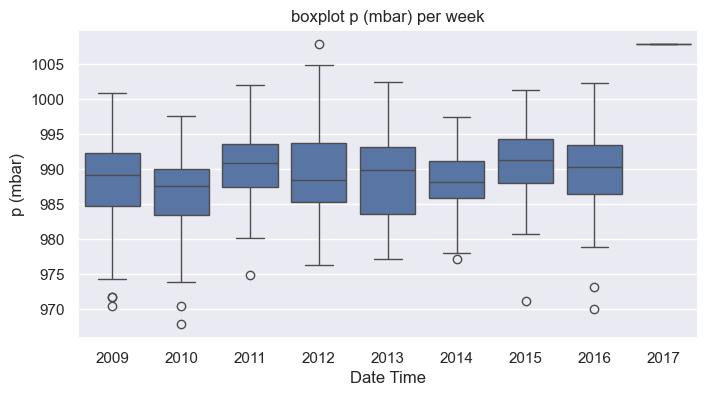

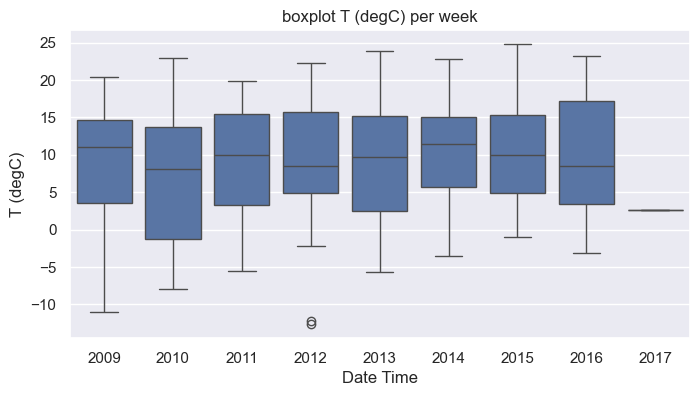

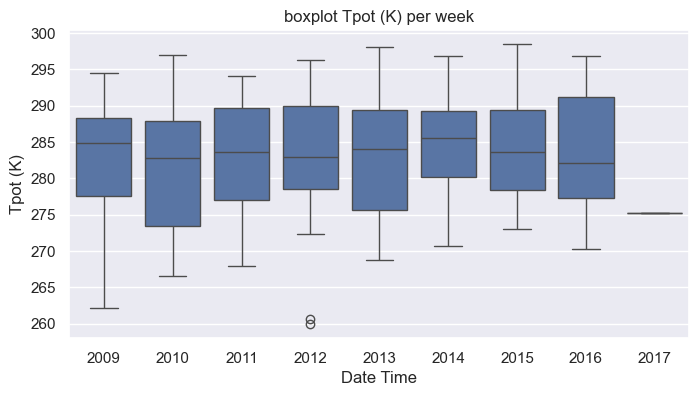

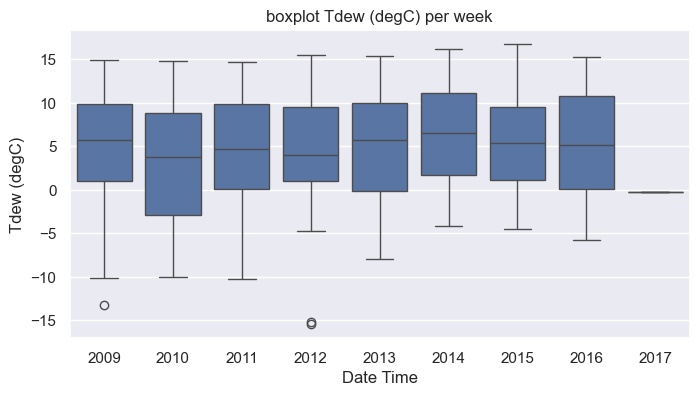

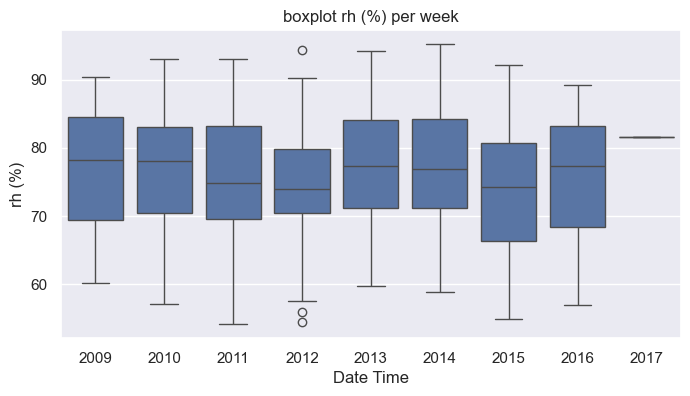

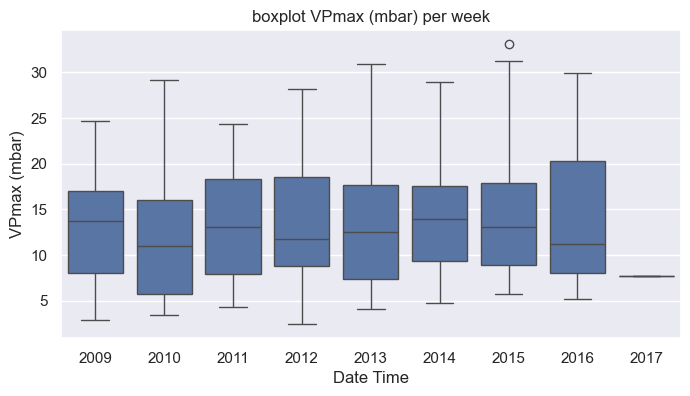

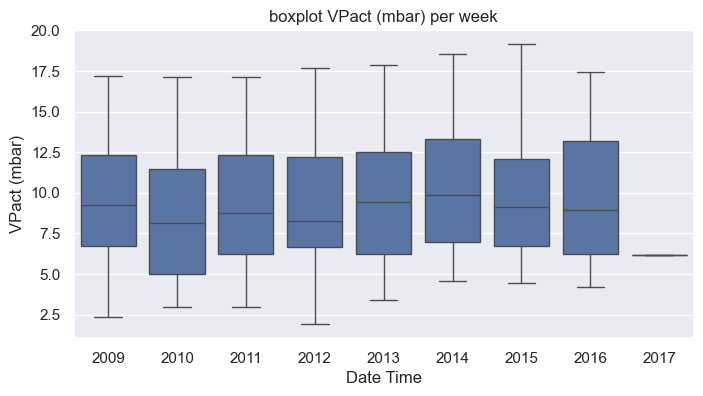

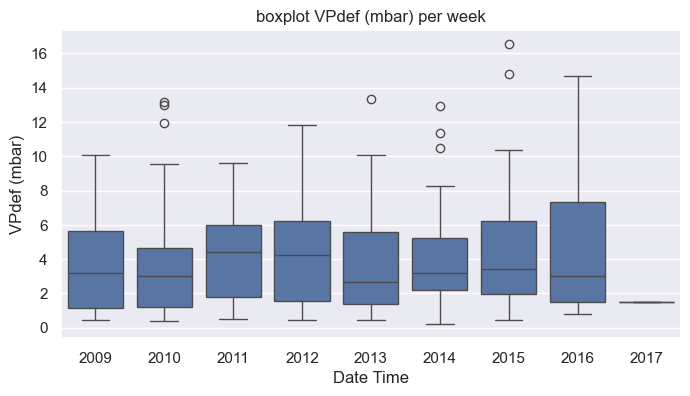

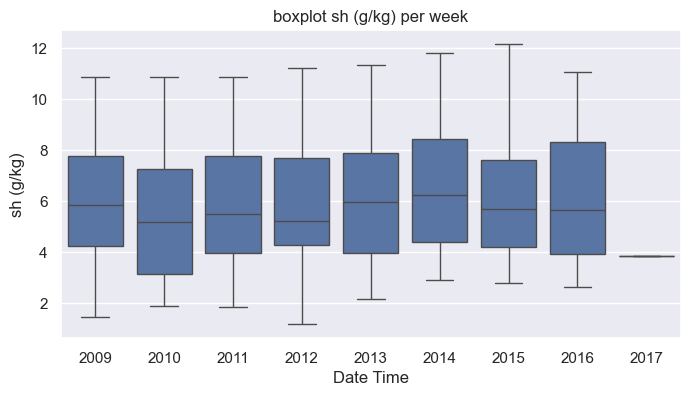

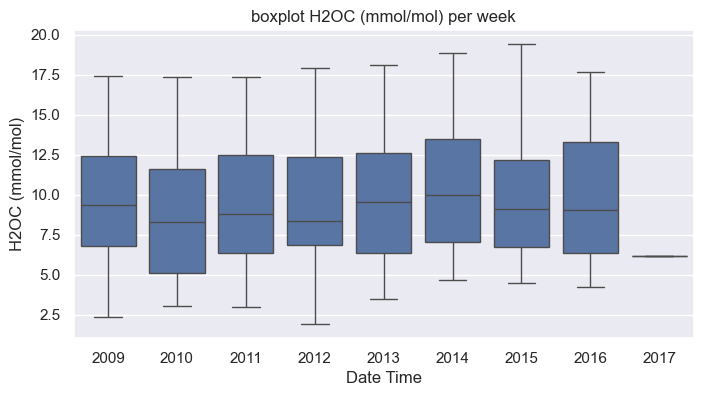

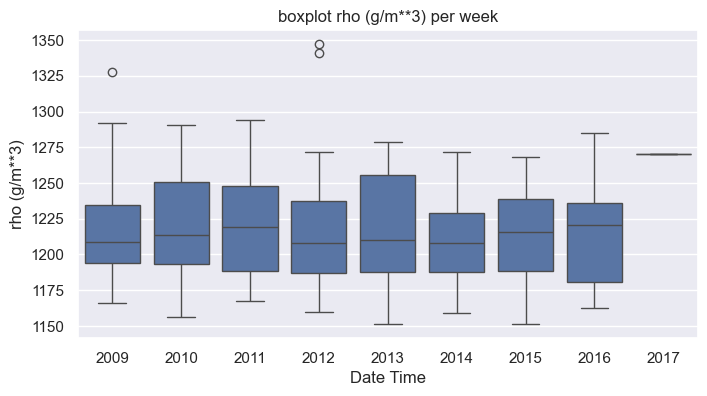

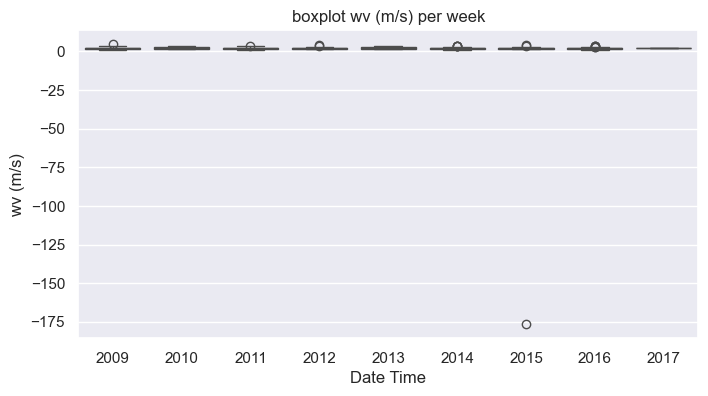

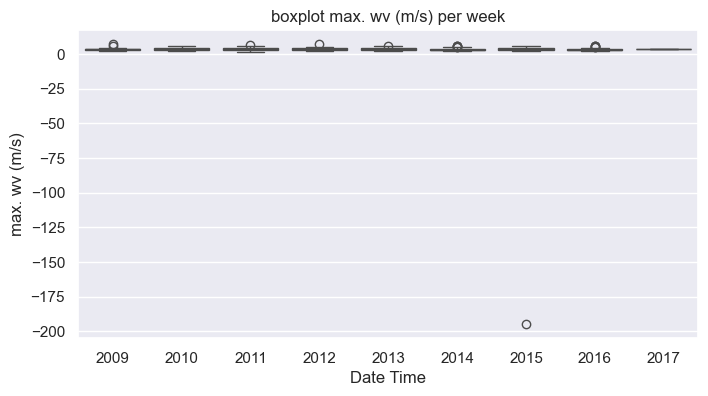

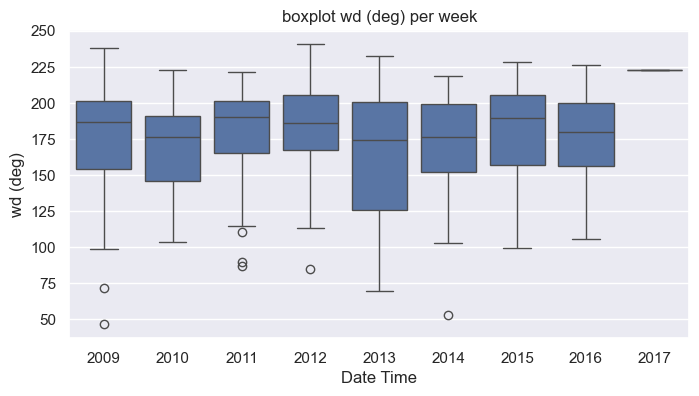

In [22]:
#Boxplot
# plot all the data
for column in Weather_data_wk.columns:
    plt.figure(figsize=(8,4))
    #plt.plot(Weather_data_wk[column])
    #plt.grid(True, color = 'k', linestyle = ':')
    plt.title('boxplot ' + column + ' per week')
    #plt.xlabel('Week')
    #plt.ylabel(column)
    sns.boxplot(x = Weather_data_wk.index.year, y = Weather_data_wk[column])
    plt.show()

outliers in wv

### Outliers

i decide to use the standard deviation method

In [23]:
for column in Weather_data_wk.columns:
    print('---------------------------')
    print(f'Outlier with standard deviation method for {column}')
    mean_value = np.mean(Weather_data_wk[column]) #calcolo la media
    sd_value = np.std(Weather_data_wk[column]) #calcolo lo sd
    thr = 3*sd_value 
    Lower = mean_value - thr
    Upper = mean_value + thr

    outliers = [i for i in Weather_data_wk[column] if i < Lower or i > Upper] #prendo tutti i valori fuori dal limite -> outlier
    print('Number of outliers:', len(outliers))
    print('Outliers:', outliers)

    P_no_outliers = [i for i in Weather_data_wk[column] if i > Lower and i < Upper]
    print('Number of non-outliers:', len(P_no_outliers))

---------------------------
Outlier with standard deviation method for p (mbar)
Number of outliers: 5
Outliers: [970.4863194444445, 970.3948611111111, 967.8167956349206, 970.0243253968254, 1007.8895486111111]
Number of non-outliers: 413
---------------------------
Outlier with standard deviation method for T (degC)
Number of outliers: 0
Outliers: []
Number of non-outliers: 418
---------------------------
Outlier with standard deviation method for Tpot (K)
Number of outliers: 2
Outliers: [260.60050595238096, 259.93815476190474]
Number of non-outliers: 416
---------------------------
Outlier with standard deviation method for Tdew (degC)
Number of outliers: 2
Outliers: [-15.153799603174603, -15.437232142857143]
Number of non-outliers: 416
---------------------------
Outlier with standard deviation method for rh (%)
Number of outliers: 0
Outliers: []
Number of non-outliers: 418
---------------------------
Outlier with standard deviation method for VPmax (mbar)
Number of outliers: 1
Outlie

come possiamo vedere in wm e max wm abbiamo trovato gli outlier maggiori 

Per quanto rigurda la temperatura in C non abbiamo trovato outliers

### Correlation

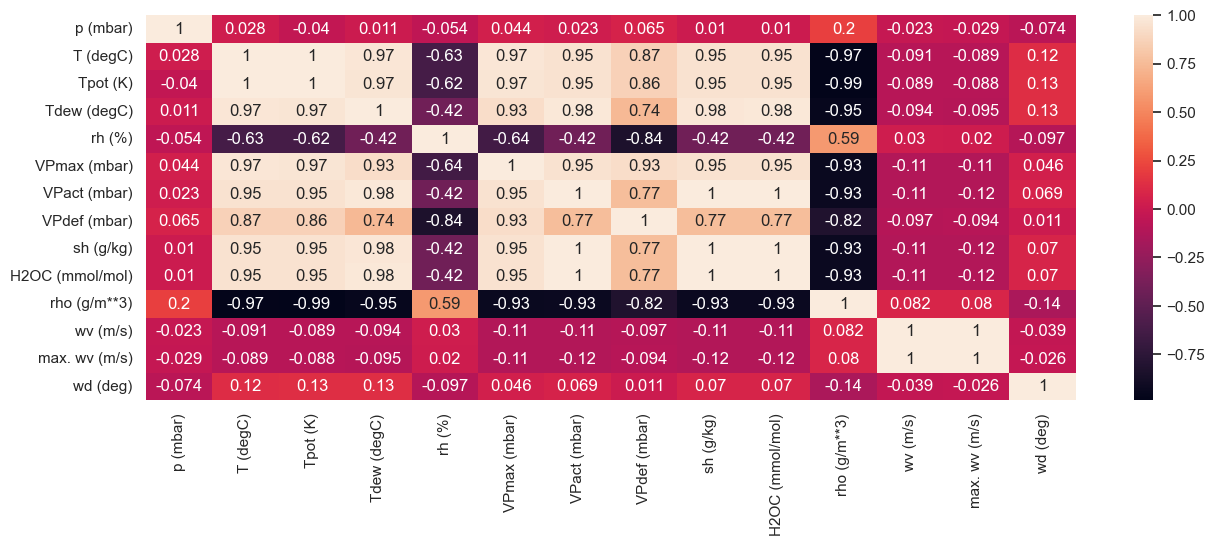

In [24]:
plt.figure(figsize=(15,5))
sns.heatmap(Weather_data_wk.corr(), annot=True)
plt.show()

correlazioni importanti per creare exogenouse variables per T (degC):
-   VPmax (mbar) = Saturation vapor pressure
-   VPact (mbar) = Vapor pressure
-   sh (g/kg) = Specific humidity
-   H2OC (mmol/mol) = Water vapor concentration
-   rho (g/m**3) = Airtight

METTERE EFFETIVAMNETE UNA DESCRIZIONE

### Autocorrelation

MI SA CHE TOLGO QUESTA PARTE, QUA è INUTILE SERVE IN THE DESCIBING TIME SERIES

In [25]:
'''# plot all the data
for column in Weather_data_wk.columns:
    plt.figure(figsize=(8,4))
    plot_acf(Weather_data_wk[column], lags=12)
    plt.title('Autocorrelation function for ' + column)
    plt.xlabel('LAG??')
    plt.ylabel('Autocorrelation')
    plt.show()
    
#matplotlib.pyplot.close()'''

"# plot all the data\nfor column in Weather_data_wk.columns:\n    plt.figure(figsize=(8,4))\n    plot_acf(Weather_data_wk[column], lags=12)\n    plt.title('Autocorrelation function for ' + column)\n    plt.xlabel('LAG??')\n    plt.ylabel('Autocorrelation')\n    plt.show()\n    \n#matplotlib.pyplot.close()"

per la maggior parte abbiamo un seasonality che si ripete ogni 1 mese/ 1 lag, in più la autocorrelazione è sempre positiva (RIVEDER)

## Frequency Analysis


vedere la lezione 6 fatta dalla prof

solo sulla temperatura

### FFT and Amplitude Spectrum

In [26]:
'''# FFT and Amplitude Spectrum
for column in Weather_data_wk_train.columns:
    Fs = 1 # sampling rate, our unit of measure is "months" (Important!) --> the data are sampled monthly, thus the sampling rate is 1 sample per month
    X = fft(Weather_data_wk_train[column].values)
    N = len(X)
    freq_step = Fs/N
    freq_vec = np.arange(0,Fs,freq_step)

    ampl = np.abs(X[1:])/N # Start from 1 to remove the zero frequency component, called DC
    freq_vec = freq_vec[1:]
    plt.plot(freq_vec,ampl)
    plt.title(f'Double Sided FFT for {column}')
    plt.xlabel('Frequency')
    plt.ylabel('FFT Amplitude |X(freq)|')
    plt.show()'''

'# FFT and Amplitude Spectrum\nfor column in Weather_data_wk_train.columns:\n    Fs = 1 # sampling rate, our unit of measure is "months" (Important!) --> the data are sampled monthly, thus the sampling rate is 1 sample per month\n    X = fft(Weather_data_wk_train[column].values)\n    N = len(X)\n    freq_step = Fs/N\n    freq_vec = np.arange(0,Fs,freq_step)\n\n    ampl = np.abs(X[1:])/N # Start from 1 to remove the zero frequency component, called DC\n    freq_vec = freq_vec[1:]\n    plt.plot(freq_vec,ampl)\n    plt.title(f\'Double Sided FFT for {column}\')\n    plt.xlabel(\'Frequency\')\n    plt.ylabel(\'FFT Amplitude |X(freq)|\')\n    plt.show()'

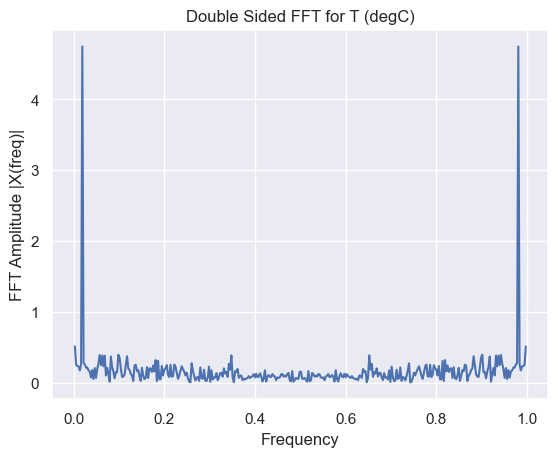

In [27]:
Fs = 1 # sampling rate, our unit of measure is "months" (Important!) --> the data are sampled monthly, thus the sampling rate is 1 sample per month
X = fft(Weather_data_wk_train['T (degC)'].values)
N = len(X)
freq_step = Fs/N
freq_vec = np.arange(0,Fs,freq_step)

ampl = np.abs(X[1:])/N # Start from 1 to remove the zero frequency component, called DC
freq_vec = freq_vec[1:]
plt.plot(freq_vec,ampl)
plt.title(f'Double Sided FFT for T (degC)')
plt.xlabel('Frequency')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.show()

### Power Spectral Density (PSD)

### Power Spectral Density (PSD) based on Periodgram

#### test 1

In [28]:
'''#create a dizio to save the period
dizio_period = {}

for column in Weather_data_wk.columns:
    ###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.
    f_per, Pxx_per = signal.periodogram(Weather_data_wk[column],1,detrend=None,window='hann',return_onesided=True,scaling='density')
    f_per = f_per[1:]
    Pxx_per = Pxx_per[1:]

    #Find the peaks of the periodogram.
    #peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=(Pxx_per) * 0.001)[0]
    peaks = signal.find_peaks(Pxx_per[f_per >= 0])[0]
    peak_freq = f_per[peaks]
    peak_dens = Pxx_per[peaks]

    #Plot of the analysis transformation and of its peaks. Only the first five are interestings
    fig = plt.figure(figsize=(16,6))
    plt.plot(peak_freq, peak_dens, 'ro')
    plt.plot(f_per[2:],Pxx_per[2:])
    plt.xlabel('Frequency')
    plt.ylabel('Density')
    plt.title(f'PSD using periodgram for {column}')
    plt.show()

    #Retrieving of the values
    data = {'Frequency': peak_freq, 'Density': peak_dens, 'Period': 1/peak_freq}
    df = pd.DataFrame(data) #ATTENZIONE ORDINARE PER DENISTA
    df.sort_values('Density', ascending=False, inplace=True, ignore_index=True)
    display(df.head()) #come possimao vedere il più frequete è 12

    dizio_period[column] = df.loc[0,'Period']'''


"#create a dizio to save the period\ndizio_period = {}\n\nfor column in Weather_data_wk.columns:\n    ###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.\n    f_per, Pxx_per = signal.periodogram(Weather_data_wk[column],1,detrend=None,window='hann',return_onesided=True,scaling='density')\n    f_per = f_per[1:]\n    Pxx_per = Pxx_per[1:]\n\n    #Find the peaks of the periodogram.\n    #peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=(Pxx_per) * 0.001)[0]\n    peaks = signal.find_peaks(Pxx_per[f_per >= 0])[0]\n    peak_freq = f_per[peaks]\n    peak_dens = Pxx_per[peaks]\n\n    #Plot of the analysis transformation and of its peaks. Only the first five are interestings\n    fig = plt.figure(figsize=(16,6))\n    plt.plot(peak_freq, peak_dens, 'ro')\n    plt.plot(f_per[2:],Pxx_per[2:])\n    plt.xlabel('Frequency')\n    plt.ylabel('Density')\n    plt.title(f'PSD using periodgram for {column}')\n    plt.show()\n\n    #Retrieving of the values\n  

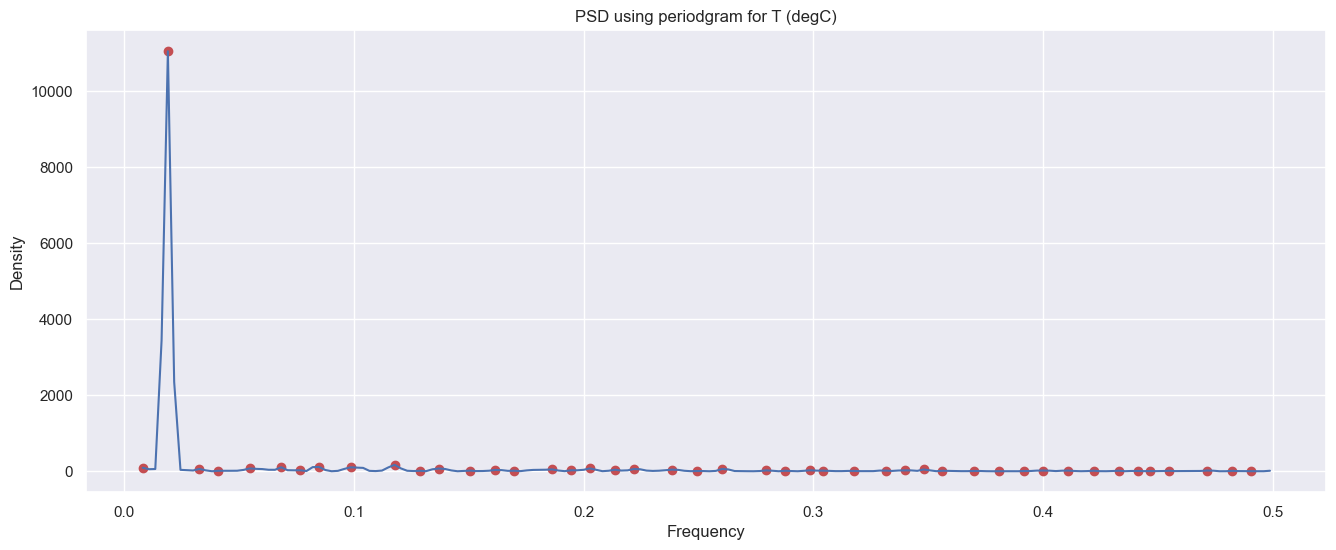

Frequency       Density     Period
0   0.019178  11059.782553  52.142857
1   0.117808    169.316720   8.488372
2   0.084932    113.229485  11.774194
3   0.068493    105.509285  14.600000
4   0.098630    103.482978  10.138889

In [29]:
#create a dizio to save the period
dizio_period = {}


###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.
f_per, Pxx_per = signal.periodogram(Weather_data_wk_train['T (degC)'], 1, detrend=None, window='hann', return_onesided=True, scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

#Find the peaks of the periodogram.
#peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=(Pxx_per) * 0.001)[0]
peaks = signal.find_peaks(Pxx_per[f_per >= 0])[0]
peak_freq = f_per[peaks]
peak_dens = Pxx_per[peaks]

#Plot of the analysis transformation and of its peaks. Only the first five are interestings
fig = plt.figure(figsize=(16,6))
plt.plot(peak_freq, peak_dens, 'ro')
plt.plot(f_per[2:],Pxx_per[2:])
plt.xlabel('Frequency')
plt.ylabel('Density')
plt.title(f'PSD using periodgram for T (degC)')
plt.show()

#Retrieving of the values
data = {'Frequency': peak_freq, 'Density': peak_dens, 'Period': 1/peak_freq}
df = pd.DataFrame(data) #ATTENZIONE ORDINARE PER DENISTA
df.sort_values('Density', ascending=False, inplace=True, ignore_index=True)
display(df.head()) #come possimao vedere il più frequete è 12

dizio_period['T (degC)'] = df.loc[0,'Period']

In [30]:
dizio_period

{'T (degC)': 52.14285714285714}

#### test 2

In [31]:
'''for column in Weather_data_wk:
    # (Optional) Check with the frequency analysis (PSD) the frequency of the time series (train data), to conferm the seasonality value to be included in the forecasting
    Fs = 1 # our unit of measures is "months", thus 1 per month
    f_per, Pxx_per = signal.periodogram(Weather_data_wk[column],Fs,detrend=False,window='boxcar',return_onesided=True,scaling='density')
    f_per = f_per[1:]
    Pxx_per = Pxx_per[1:]
    plt.plot(f_per,Pxx_per)
    plt.xlabel('Frequency [cycles/month]')
    plt.title(column)

    peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]
    peak_freq =  f_per[peaks]
    peak_power = Pxx_per[peaks]
    plt.plot(peak_freq, peak_power, 'ro')
    plt.show()

    data = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
    df = pd.DataFrame(data)
    display(df)'''

'for column in Weather_data_wk:\n    # (Optional) Check with the frequency analysis (PSD) the frequency of the time series (train data), to conferm the seasonality value to be included in the forecasting\n    Fs = 1 # our unit of measures is "months", thus 1 per month\n    f_per, Pxx_per = signal.periodogram(Weather_data_wk[column],Fs,detrend=False,window=\'boxcar\',return_onesided=True,scaling=\'density\')\n    f_per = f_per[1:]\n    Pxx_per = Pxx_per[1:]\n    plt.plot(f_per,Pxx_per)\n    plt.xlabel(\'Frequency [cycles/month]\')\n    plt.title(column)\n\n    peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]\n    peak_freq =  f_per[peaks]\n    peak_power = Pxx_per[peaks]\n    plt.plot(peak_freq, peak_power, \'ro\')\n    plt.show()\n\n    data = {\'Freq\': peak_freq, \'Period\': 1/peak_freq, \'Power\': peak_power}\n    df = pd.DataFrame(data)\n    display(df)'

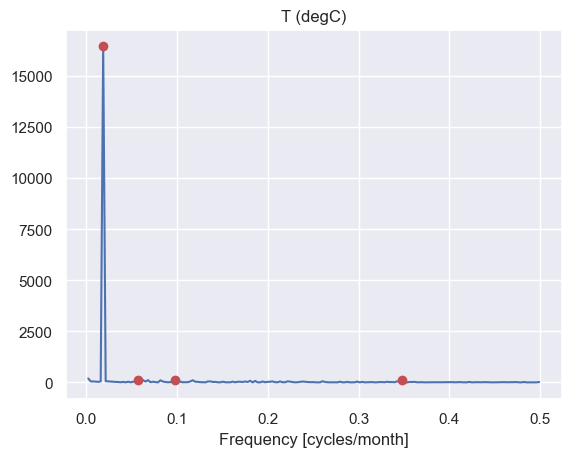

Freq     Period         Power
0  0.019178  52.142857  16456.709324
1  0.057534  17.380952    112.708219
2  0.098630  10.138889    115.229860
3  0.347945   2.874016    109.511200

In [32]:
# (Optional) Check with the frequency analysis (PSD) the frequency of the time series (train data), to conferm the seasonality value to be included in the forecasting
Fs = 1 # our unit of measures is "months", thus 1 per month
f_per, Pxx_per = signal.periodogram(Weather_data_wk_train['T (degC)'], Fs, detrend=False, window='boxcar', return_onesided=True, scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]
plt.plot(f_per,Pxx_per)
plt.xlabel('Frequency [cycles/month]')
plt.title('T (degC)')

peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]
peak_freq =  f_per[peaks]
peak_power = Pxx_per[peaks]
plt.plot(peak_freq, peak_power, 'ro')
plt.show()

data = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
df = pd.DataFrame(data)
display(df)

# DESCRIBING THE TIME SERIES PATTERS

In [33]:
temp = Weather_data_wk_train['T (degC)']

## Stationarity

first we have to check the stationary of the time series, we do this becouse many statistical model require the series to be stationary to make effective and precise predictions. 
To check the stationary we can:
-   check mean and standard deviation (have to be constant over the time)
-   use the ACF (we can also spot presence of seasonality or trend)
-   statistical hypotesis test like ADF and KPSS

### Check mean and standard deviation (Rolling statistics)

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

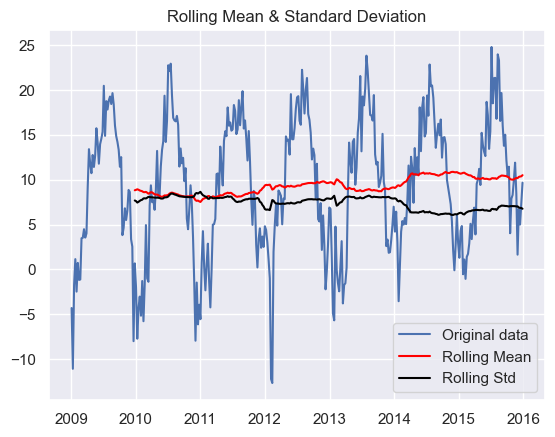

In [34]:
rolling_mean = temp.rolling(52).mean() #parameter window -> contain the lsat 52 observation (so 1 year) and calculate the mean  (CREDO)
rolling_std = temp.rolling(52).std()
plt.plot(temp, label='Original data')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

Like we can see form the plot the mean start to increse during the time so it is mean that maybe the series is not stationary also we see a cycle that it repeat every year.

For the standard deviation we can see that have a constant behaviour over the years maybe a small decline (mmm forse è sbagliato, sembra che il trend a standard deviation siamo inversamente proporzionali??)

### ACF and PACF

can be use to identify possible components of the time series and understand if the ts can be stationary or not??

Note: we know from frequancy analysis that for the feature T (dec) the seasonal periond is equal to 52

ACF and PACF for non-seasonal part (AR) 

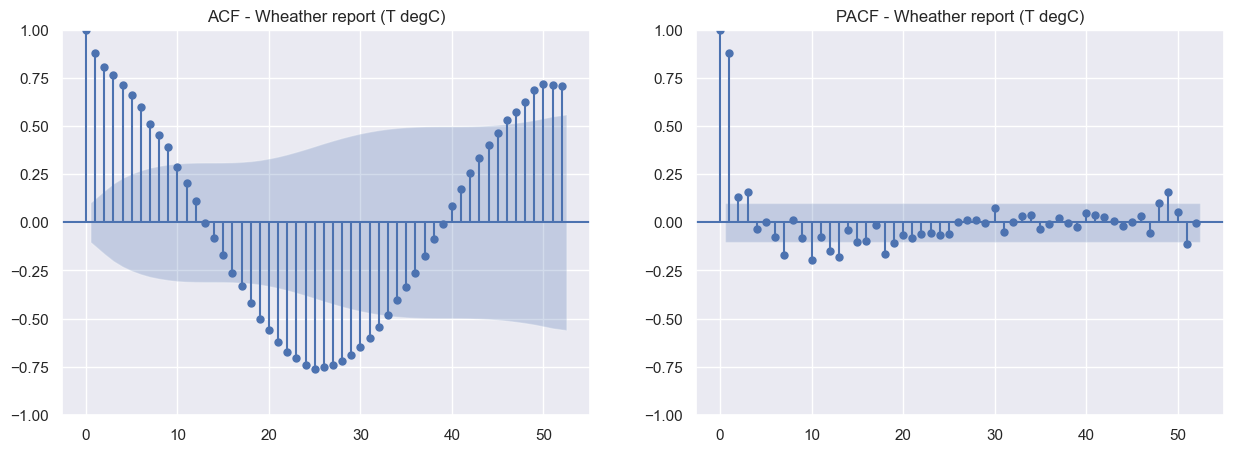

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(temp, lags=52, ax=ax[0], title='ACF - Wheather report (T degC)')
plot_pacf(temp, lags=52, ax=ax[1], title='PACF - Wheather report (T degC)')
plt.show()

AR(p) -> p = 1??

ACF and PACF for the seasonal part

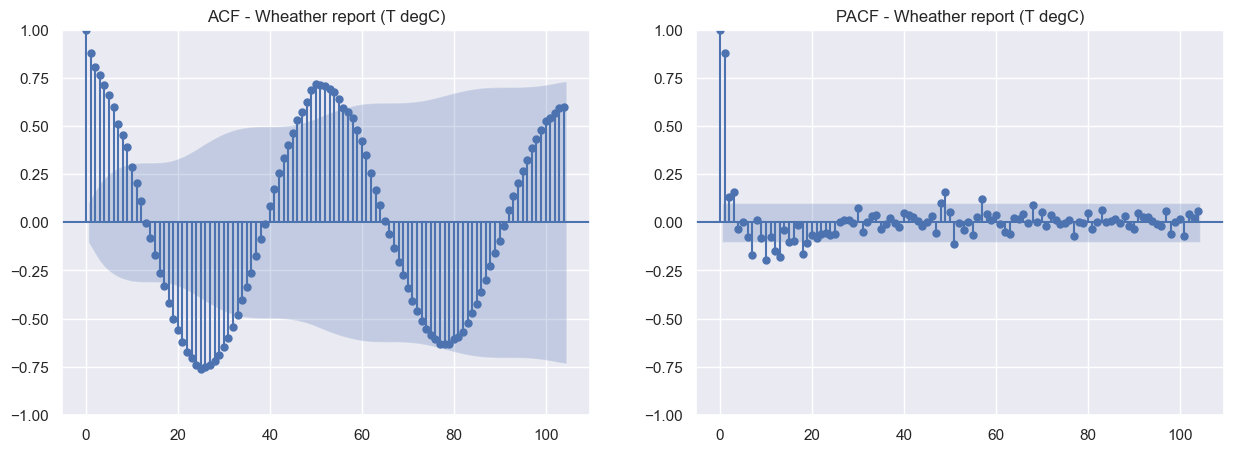

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(temp, lags=104, ax=ax[0], title='ACF - Wheather report (T degC)')
plot_pacf(temp, lags=104, ax=ax[1], title='PACF - Wheather report (T degC)')
plt.show()

we can see that the acf increase and decrease so it is means that there are a presence of a trend (start with positive values and slowly decriseas the lags increse; it is also true at the lag 25/26 from negative to positive ?? seconda osservazione penso sia sbagliata perchè in generale + lag mettiamo più si restinge in generale provare a mettere 208) and seasonality (the ACF are larger for the leasonal lags?? secondo me posso dire che semplicemente si vede una ripetizione di certi picchi che è uguale a 52) (SCRIVERE MEGLIO)

### ADF and KPSS

In [37]:
# ADF test
adf_test = adfuller(temp,autolag='AIC') 
print('ADF Statistic:', adf_test[0])
print('p-value - ADF: ', adf_test[1])
print('------------------------------')

# p > 0.05 --> We reject the null hypothesis, meaning the data is not-stationary, as expected from the plot

# KPSS test option 1
kpss_test = kpss(temp, regression='c', nlags='auto', store=True) 
print('KPSS Statistic - c:', kpss_test[0])
print('p-value - c: ', kpss_test[1])
print('------------------------------')

# p < 0.05 --> We reject the null hypothesis, meaning the data is non-stationary.
# This because the "c" option tests for stationarity around a ‘mean’ only

# KPSS test option 2
kpss_test = kpss(temp, regression='ct', nlags='auto', store=True)
print('KPSS Statistic - ct:', kpss_test[0])
print('p-value - ct: ', kpss_test[1])
print('------------------------------')

# p > 0.05 --> We can not reject the null hypothesis, meaning the data is trend stationary

ADF Statistic: -7.945514086336788
p-value - ADF:  3.2279831966229144e-12
------------------------------
KPSS Statistic - c: 0.10545784665825468
p-value - c:  0.1
------------------------------
KPSS Statistic - ct: 0.020274605447635607
p-value - ct:  0.1
------------------------------


C:\Users\elped\AppData\Local\Temp\ipykernel_12972\690312634.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(temp, regression='c', nlags='auto', store=True)
C:\Users\elped\AppData\Local\Temp\ipykernel_12972\690312634.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(temp, regression='ct', nlags='auto', store=True)


In [38]:
def kpss_test(data):
  kpss_out = kpss(data,regression='c', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> unit root, data is not stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')


print('KPSS on Temperature')
kpss_test(temp)


KPSS on Temperature
KPSS Statistic: 0.10545784665825468
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


C:\Users\elped\AppData\Local\Temp\ipykernel_12972\4054022506.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_out = kpss(data,regression='c', nlags='auto', store=True)


In [39]:
# ADF on the different data from previous examples

def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')


print('ADF on Temperature')
adfuller_test(temp)
# p > 0.05 --> We cannot reject the null hypothesis (H0), meaning data the data has a unit root and is non-stationary.
# p <= 0.05 --> We reject the null hypothesis (H0), meaning data the data has not a unit root and is stationary.

ADF on Temperature
ADF Statistic: -7.945514086336788
p-value:  3.2279831966229144e-12
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
We can reject the null hypothesis (H0) --> data is stationary


La time series risulta stazionaria

Come ???? non ce seasonality?? non ho capito qualcosa
RICONTROLLARE

see differencing and logarithm transformation

## Seasonality

try to remove seasonality, but i think this is useless becouse is already stationary the ts

In [40]:
temp_diff_seas = temp.diff(52).dropna()

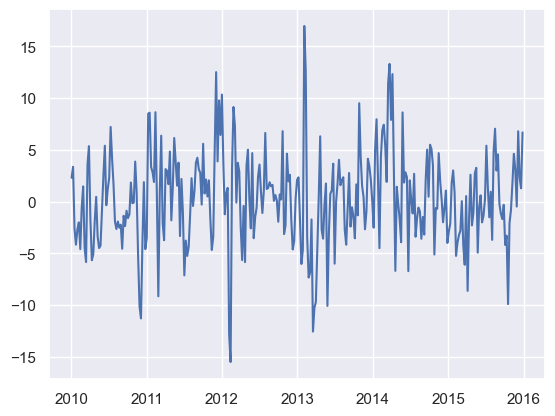

In [41]:
plt.figure()
plt.plot(temp_diff_seas)
plt.show()

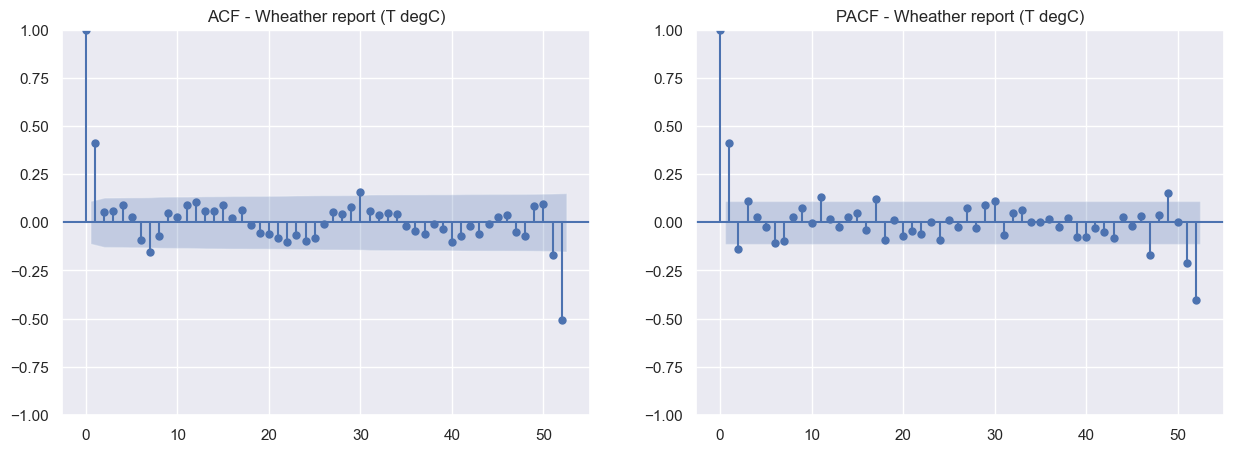

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(temp_diff_seas, lags=52, ax=ax[0], title='ACF - Wheather report (T degC)')
plot_pacf(temp_diff_seas, lags=52, ax=ax[1], title='PACF - Wheather report (T degC)')
plt.show()

In [43]:
'''# ADF test
adf_test = adfuller(temp_diff,autolag='AIC') 
print('ADF Statistic:', adf_test[0])
print('p-value - ADF: ', adf_test[1])
print('------------------------------')

# p > 0.05 --> We reject the null hypothesis, meaning the data is not-stationary, as expected from the plot

# KPSS test option 1
kpss_test = kpss(temp_diff, regression='c', nlags='auto', store=True) 
print('KPSS Statistic - c:', kpss_test[0])
print('p-value - c: ', kpss_test[1])
print('------------------------------')

# p < 0.05 --> We reject the null hypothesis, meaning the data is non-stationary.
# This because the "c" option tests for stationarity around a ‘mean’ only

# KPSS test option 2
kpss_test = kpss(temp_diff, regression='ct', nlags='auto', store=True)
print('KPSS Statistic - ct:', kpss_test[0])
print('p-value - ct: ', kpss_test[1])
print('------------------------------')

# p > 0.05 --> We can not reject the null hypothesis, meaning the data is trend stationary'''

'# ADF test\nadf_test = adfuller(temp_diff,autolag=\'AIC\') \nprint(\'ADF Statistic:\', adf_test[0])\nprint(\'p-value - ADF: \', adf_test[1])\nprint(\'------------------------------\')\n\n# p > 0.05 --> We reject the null hypothesis, meaning the data is not-stationary, as expected from the plot\n\n# KPSS test option 1\nkpss_test = kpss(temp_diff, regression=\'c\', nlags=\'auto\', store=True) \nprint(\'KPSS Statistic - c:\', kpss_test[0])\nprint(\'p-value - c: \', kpss_test[1])\nprint(\'------------------------------\')\n\n# p < 0.05 --> We reject the null hypothesis, meaning the data is non-stationary.\n# This because the "c" option tests for stationarity around a ‘mean’ only\n\n# KPSS test option 2\nkpss_test = kpss(temp_diff, regression=\'ct\', nlags=\'auto\', store=True)\nprint(\'KPSS Statistic - ct:\', kpss_test[0])\nprint(\'p-value - ct: \', kpss_test[1])\nprint(\'------------------------------\')\n\n# p > 0.05 --> We can not reject the null hypothesis, meaning the data is trend s

to check the seasonality for the temperature see the chapter Frequency Analysis -> PSD

## Decomposition

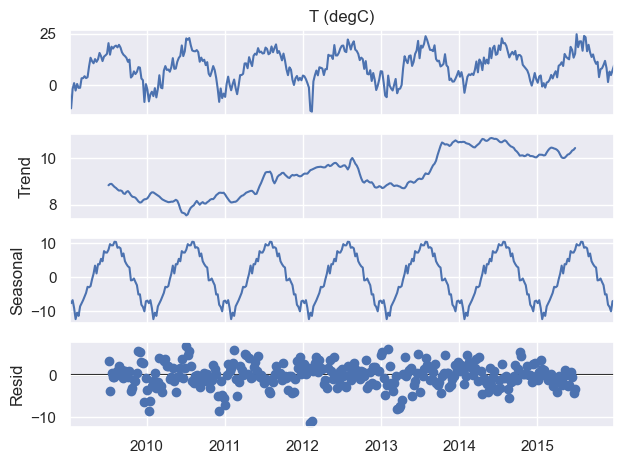

In [44]:
decompose_data_add = seasonal_decompose(Weather_data_wk_train['T (degC)'], model='additive', period = int(dizio_period['T (degC)'])) # period is automatically set to 12, considering the monthly data
decompose_data_add.plot()
plt.show()

simao sicuri che non sia una roba della frequency analysis??

# FORECASTING

stampare i plot diagnosis!!

In [45]:
# feature to forecast
feature = 'T (degC)'

In [46]:
#final test and train
train = Weather_data_wk_train[feature]
#display(train)
test = Weather_data_wk_test[feature]
#display(test)

In [47]:
#df to take track of the precision of the models
df_accuracy = pd.DataFrame(columns=['Model','AIC','RMSE','MAE'])
display(df_accuracy)

Empty DataFrame
Columns: [Model, AIC, RMSE, MAE]
Index: []

AUTOMATIZZARE LA SCELTA DEL PERIODO!!!

## Simple forecasting approaches

### Mean method

In [48]:
# 1) Mean method --> the forecasts of all future values are equal to the average of the historical data
model_average = HistoricAverage()
model_average = model_average.fit(train)
#forecast_values = model_average.prediction_intervals(start = test.index[0], end=test.index[-1])
forecast_values = model_average.predict(len(test))
#display(forecast_values['mean'])

#time
#start_date = test.index[0]
#end_date = test.index[-1]
#final_date_pred = pd.date_range(start=start_date, end=end_date, freq = 'W')
#final_date_pred = test.index

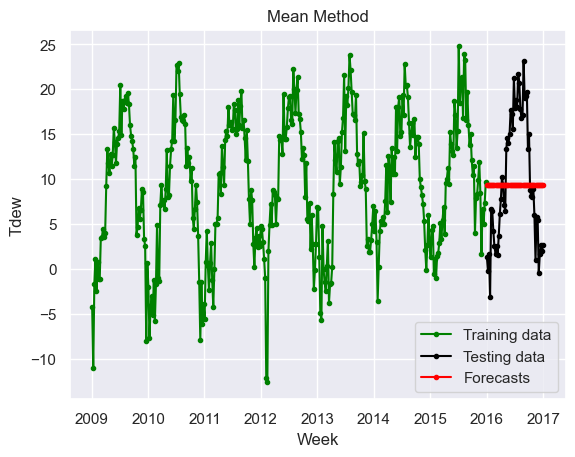

In [49]:
plt.figure()
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot(test.index,forecast_values['mean'], color='red', marker = '.', label='Forecasts' )
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Mean Method')
plt.legend()
plt.show()

### Naive method

In [50]:
#Naive Method --> we simply set all forecasts to be the value of the last observation
# Model, fitting and forecasting (20 samples)
model_Naive = Naive()
model_Naive = model_Naive.fit(train)
forecast_values = model_Naive.predict(len(test)) # same forecasting horizon as before
# forecast_values: Dictionary with entries mean for point predictions
#display(forecast_values['mean'])


c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\utils.py:297: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fcst = {"mean": _repeat_val(val=y[-1], h=h)}


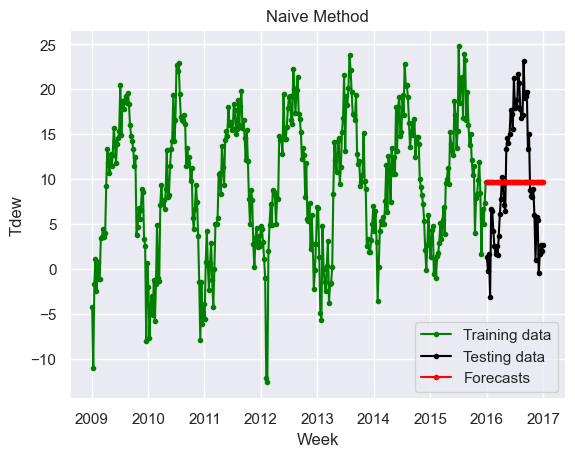

In [51]:
plt.figure()
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot(test.index, forecast_values['mean'], color='red', marker = '.', label='Forecasts' )
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Naive Method')
plt.legend()
plt.show()

### Seasonal Naive method

In [52]:
# Seasonal Naive Method --> similar to the naive, but uses the last known observation of the same period
model_Seasonal = SeasonalNaive(season_length=52) # seasonality has to be specified
model_Seasonal = model_Seasonal.fit(train)
forecast_values = model_Seasonal.predict(len(test)) # same forecasting horizon as before
# forecast_values: Dictionary with entries mean for point predictions
#display(forecast_values['mean'])

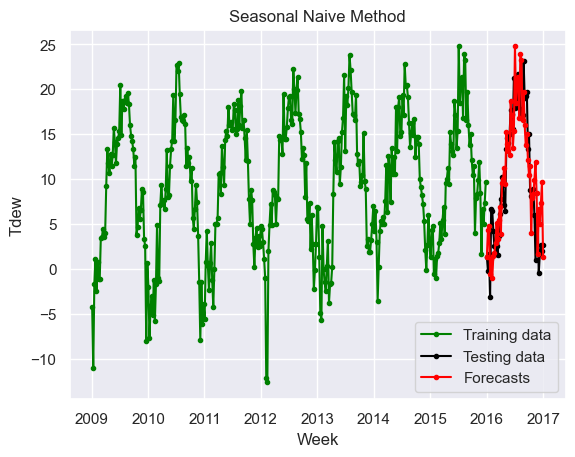

In [53]:
plt.figure()
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot(test.index, forecast_values['mean'], color='red', marker = '.', label='Forecasts' )
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Seasonal Naive Method')
plt.legend()
plt.show()

In [54]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Seasonal Naive Method', 'AIC':'', 'RMSE':root_mean_squared_error(test, forecast_values['mean']), 'MAE':mean_absolute_error(test, forecast_values['mean'])},index=[0])], ignore_index=True)

C:\Users\elped\AppData\Local\Temp\ipykernel_12972\3951454795.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Seasonal Naive Method', 'AIC':'', 'RMSE':root_mean_squared_error(test, forecast_values['mean']), 'MAE':mean_absolute_error(test, forecast_values['mean'])},index=[0])], ignore_index=True)


### Drift method

si puà chiamare trend?????

In [55]:
# Drift Method --> variation on naive, it allows the forecasts to increase or decrease over time (amout of change is called drift)
# Model, fitting and forecasting (20 samples)
model_Drift = RandomWalkWithDrift()
model_Drift = model_Drift.fit(train)
forecast_values = model_Drift.predict(len(test)) # same forecasting horizon as before

#display(forecast_values['mean'])


c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\models.py:3019: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = (y[-1] - y[0]) / (y.size - 1)
c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\models.py:3020: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = slope * (1 + np.arange(h, dtype=y.dtype)) + y[-1]
c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\models.py:3024: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

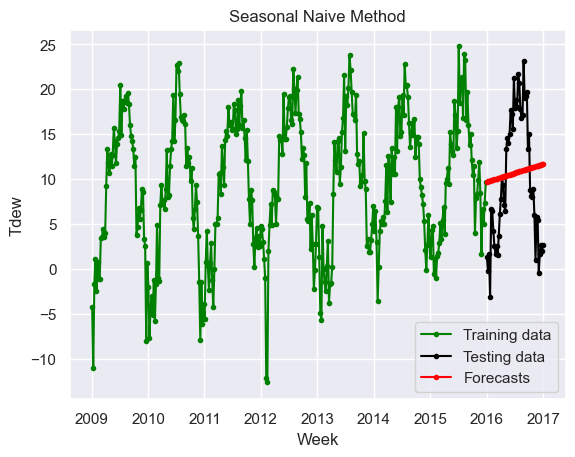

In [56]:
plt.figure()
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot(test.index, forecast_values['mean'], color='red', marker = '.', label='Forecasts' )
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Seasonal Naive Method')
plt.legend()
plt.show()

## Exponential Smoothing Additive Single

In [57]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESAS = ETSModel(train, error='add').fit()
#make the prediction
pred = modelESAS.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESAS = pred.summary_frame()
#take the forecasting
forecasts = df_modelESAS['mean']

#df_modelESAS = np.exp(df_modelESAS) #nel caso venga fatto il log!!

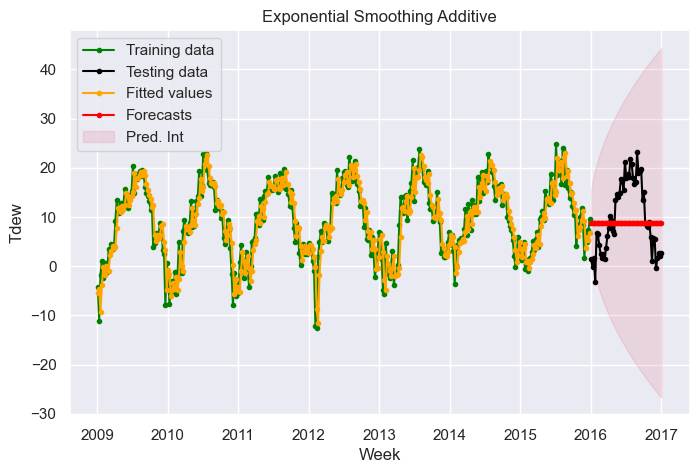

In [58]:
# Visualization
plt.figure(figsize=(8,5))
#plt.plot(np.exp(train), color='green',marker = '.',label='Training data')
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
#plt.plot(np.exp(modelESAS.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(modelESAS.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESAS.index, df_modelESAS['pi_lower'], df_modelESAS['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Exponential Smoothing Additive')
plt.legend()
plt.show()

In [59]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing Additive Single', 'AIC':modelESAS.aic, 'RMSE':root_mean_squared_error(test, df_modelESAS['mean']), 'MAE':mean_absolute_error(test, df_modelESAS['mean'])},index=[0])], ignore_index=True)

## Exponential Smoothing Additive Double

In [60]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESADouble = ETSModel(train, error='add', trend = 'add', damped_trend=False).fit()
#make the prediction
pred = modelESADouble.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESADouble = pred.summary_frame()
#take the forecasting
forecasts = df_modelESADouble['mean']

#df_modelESADouble = np.exp(df_modelESADouble) #nel caso venga fatto il log!!

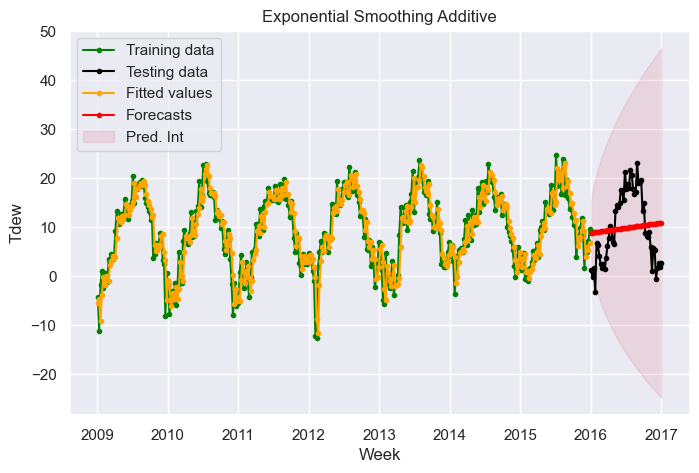

In [61]:
# Visualization
plt.figure(figsize=(8,5))
#plt.plot(np.exp(train), color='green',marker = '.',label='Training data')
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
#plt.plot(np.exp(modelESADouble.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(modelESADouble.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESADouble.index, df_modelESADouble['pi_lower'], df_modelESADouble['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Exponential Smoothing Additive')
plt.legend()
plt.show()

In [62]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing Additive Double', 'AIC':modelESADouble.aic, 'RMSE':root_mean_squared_error(test, df_modelESADouble['mean']), 'MAE':mean_absolute_error(test, df_modelESADouble['mean'])},index=[0])], ignore_index=True)

## Exponential Smoothing Additive Double Damped Trend True

In [63]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESADDouble = ETSModel(train, error='add', trend = 'add', damped_trend=True).fit()
#make the prediction
pred = modelESADDouble.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESADDouble = pred.summary_frame()
#take the forecasting
forecasts = df_modelESADDouble['mean']

#df_modelESADDouble = np.exp(df_modelESADDouble) #nel caso venga fatto il log!!

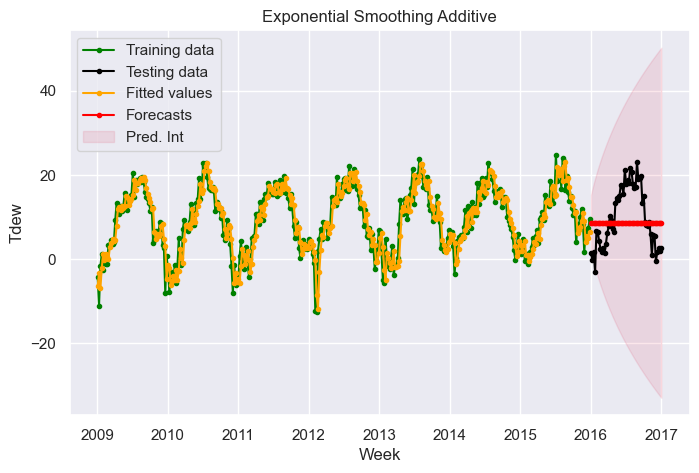

In [64]:
# Visualization
plt.figure(figsize=(8,5))
#plt.plot(np.exp(train), color='green',marker = '.',label='Training data')
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
#plt.plot(np.exp(modelESADDouble.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(modelESADDouble.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESADDouble.index, df_modelESADDouble['pi_lower'], df_modelESADDouble['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Exponential Smoothing Additive')
plt.legend()
plt.show()

like we can see from the plot it is like the ESA Single 

In [65]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing Additive Double Damped True', 'AIC':modelESADDouble.aic, 'RMSE':root_mean_squared_error(test, df_modelESADDouble['mean']), 'MAE':mean_absolute_error(test, df_modelESADDouble['mean'])},index=[0])], ignore_index=True)

## Exponential Smoothing Additive

NOTE: Models with multiplicative errors are useful for strictly positive data, but are not numerically stable with data containing zeros or negative values like in this case.
So we will test EST(A,A,Ad) and EST(A,A,A)

In [66]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESA = ETSModel(train, error='add', trend = 'add', seasonal='add', seasonal_periods=52, damped_trend=False).fit()
#make the prediction
pred = modelESA.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESA = pred.summary_frame()
#take the forecasting
forecasts = df_modelESA['mean']

#df_modelESA = np.exp(df_modelESA) #nel caso venga fatto il log!!

c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


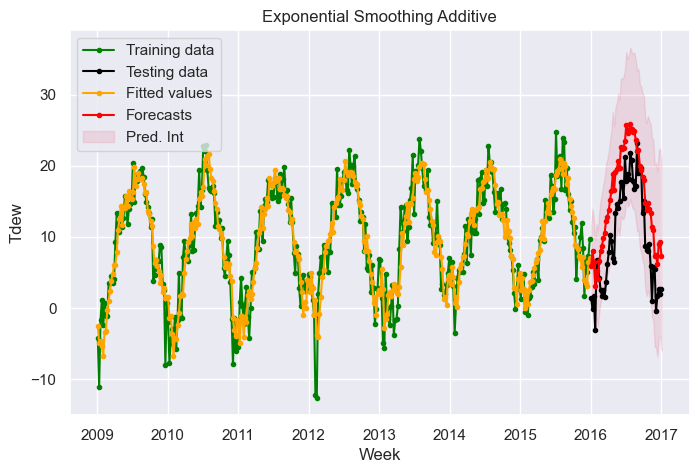

In [67]:
# Visualization
plt.figure(figsize=(8,5))
#plt.plot(np.exp(train), color='green',marker = '.',label='Training data')
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
#plt.plot(np.exp(modelESA.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(modelESA.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESA.index, df_modelESA['pi_lower'], df_modelESA['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Exponential Smoothing Additive')
plt.legend()
plt.show()

In [68]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing Additive', 'AIC':modelESA.aic, 'RMSE':root_mean_squared_error(test, df_modelESA['mean']), 'MAE':mean_absolute_error(test, df_modelESA['mean'])},index=[0])], ignore_index=True)

## Exponential Smoothing Addictive Damped Trend True

In [69]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESAd = ETSModel(train, error='add', trend = 'add', seasonal='add', seasonal_periods=52, damped_trend=True).fit()
#make the prediction
pred = modelESAd.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESAd = pred.summary_frame()
#take the forecasting
forecasts = df_modelESAd['mean']

#df_modelESAd = np.exp(df_modelESAd) #nel caso venga fatto il log!!


c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [90]:
modelESAd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               T (degC)   No. Observations:                  365
Model:                      ETS(AAdA)   Log Likelihood                -903.420
Date:                Fri, 17 Jan 2025   AIC                           1924.839
Time:                        12:09:49   BIC                           2154.933
Sample:                    01-04-2009   HQIC                          2016.282
                         - 12-27-2015   Scale                            8.268
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2146      0.071      3.022      0.003       0.075       0.354
smoothing_trend      2.146e-05        nan        nan        nan         nan         nan
smoothing_seasonal   7.854e-05        nan        nan        nan         nan         nan
damping_trend           0.8000        nan        nan        nan         nan         nan
initial_level          -8.5992   3.05e+04     -0.000      1.000   -5.97e+04    5.97e+04
initial_trend           3.5962        nan        nan        nan         nan         nan
initial_seasonal.0     -0.6967   3.05e+04  -2.29e-05      1.000   -5.97e+04    5.97e+04
initial_seasonal.1     -3.5479   3.05e+04     -0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.2     -2.1908   3.05e+04  -7.19e-05      1.000   -5.97e+04    5.97e+04
initial_seasonal.3     -2.3830   3.05e+04  -7.82e-05      1.000   -5.97e+04    5.97e+04
initial_seasonal.4      1.2223   3.05e+04   4.01e-05      1.000   -5.97e+04    5.97e+04
initial_seasonal.5      1.6543   3.05e+04   5.43e-05      1.000   -5.97e+04    5.97e+04
initial_seasonal.6      3.7286   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.7      4.2905   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.8      5.1216   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.9      4.1908   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.10     5.1720   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.11     8.2926   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.12     8.8398   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.13     9.8191   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.14    10.3734   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.15    12.6412   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.16    12.4443   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.17    14.0304   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.18    15.2757   3.05e+04      0.001      1.000   -5.97e+04    5.97e+04
initial_seasonal.19    15.2199   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.20    15.6563   3.05e+04      0.001      1.000   -5.97e+04    5.97e+04
initial_seasonal.21    16.3659   3.05e+04      0.001      1.000   -5.97e+04    5.97e+04
initial_seasonal.22    15.4637   3.05e+04      0.001      1.000   -5.97e+04    5.97e+04
initial_seasonal.23    15.0462   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.24    16.2252   3.05e+04      0.001      1.000   -5.97e+04    5.97e+04
initial_seasonal.25    13.9050   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.26    12.9474   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.27    12.8299   3.05e+04      0.000      1.000   -5.97e+

In [70]:
#df_modelESAd

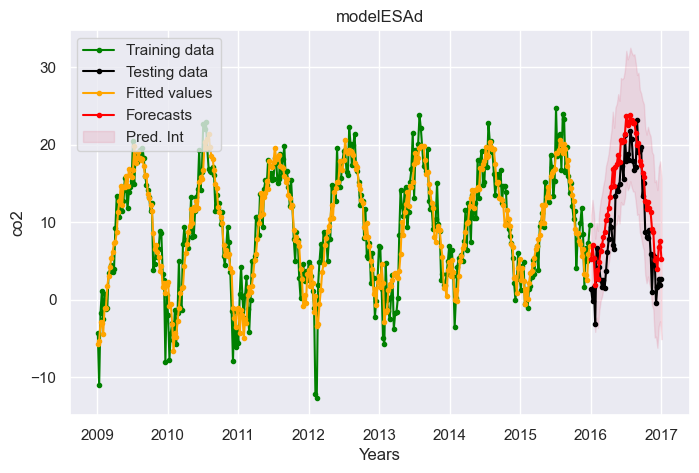

In [71]:
# Visualization #PER IL PLTO RI TRASFORMARE I DATI CON L'ESPONENZIALE!!!!!
plt.figure(figsize=(8,5))
plt.plot((train), color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot((modelESAd.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESAd.index, df_modelESAd['pi_lower'], df_modelESAd['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('co2')
plt.title('modelESAd')
plt.legend()
plt.show()

In [72]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing AD', 'AIC':modelESAd.aic, 'RMSE':root_mean_squared_error(test, df_modelESAd['mean']), 'MAE':mean_absolute_error(test, df_modelESAd['mean'])},index=[0])], ignore_index=True)

## Linear Regression

## Manual SARIMA

so we have to decide the parameter for the AR part, MA part, I and Seasonal.
From the last points we know that:
-   S = 52
-   AR (p) = 0
-   I = 0 -> perchè è già stazionario
-   MA (q) = 1

in generale:
-   non seasonal component (p,d,q) -> (0,0,0)
-   seasonl component (P,D,Q) -> (0,0,0)
-   seasonality m = 52


rivedere come capire manaulmente i valori per AR and MA, INSERIRLI NELLA PARTE DI ACF AND PACF,
VEDERE ANCHE CON ALE COME LEGGERE ACF AND PSCF DALLA LEZIONE 10!!

In [73]:
#model_SARIMA = SARIMA()

## Auto SARIMA (Auto_Arima)

we have see from the adf and kpss that the ts is alredy stationary so its mean that the d = 0 and D = 0 beacouse we don't have to differencing!!

In [74]:
'''stepwise_model = auto_arima(train, start_p=0, start_q=0, d=0,
                           max_p=5, max_q=5, m=52,
                           start_P=0, start_Q=0, max_P = 5, max_Q = 5, D = 0, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True) #TRUE altrimenti ci impiega troppo #ATTENZIONE PROVARE A MAETTERE D=1 E d=0'''

"stepwise_model = auto_arima(train, start_p=0, start_q=0, d=0,\n                           max_p=5, max_q=5, m=52,\n                           start_P=0, start_Q=0, max_P = 5, max_Q = 5, D = 0, seasonal=True,\n                           trace=True, information_criterion='aic',\n                           error_action='ignore',\n                           suppress_warnings=True,\n                           stepwise=True) #TRUE altrimenti ci impiega troppo #ATTENZIONE PROVARE A MAETTERE D=1 E d=0"

but now i try to use auto_arima with d and D equal to None so the algorithm will determine they. From waht we know also in this case the d and D have to be equal to 0

In [92]:
stepwise_model = auto_arima(train, 
                            start_p=0, start_q=0, d= None,
                            max_p=5, max_q=5, 
                            m=52,
                            start_P=0, start_Q=0, D = None,
                            max_P = 5, max_Q = 5, 
                            seasonal=True,
                            trace=True, 
                            information_criterion='aic',
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2506.210, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1947.682, Time=4.21 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2142.777, Time=2.64 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2849.806, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1950.240, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=38.07 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=5.03 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=1949.098, Time=2.01 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=1935.467, Time=30.43 sec
 ARIMA(1,0,0)(3,0,1)[52] intercept   : AIC=inf, Time=178.79 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=1936.279, Time=40.16 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=1937.126, Time=46.78 sec
 ARIMA(1,0,0)(3,0,0)[52] intercept   : AIC=inf, Time=43.19 sec
 ARIMA(1,0,0)(3,0,2)[52] intercept   : AIC=inf, Time=272.17 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept 

KeyboardInterrupt: 

In [75]:
#best oarameters
#Best model:  ARIMA(3,0,0)(2,0,0)[52] intercept
#(p, d, q) = stepwise_model.order
#(P, D, Q, S) = stepwise_model.seasonal_order
(p, d, q) = (3,0,0)
(P, D, Q, S) = (2,0,0,52)

In [76]:
#creation of the model SARIMA
model_SARIMA = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()

In [89]:
model_SARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           T (degC)   No. Observations:                  365
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 52)   Log Likelihood                -956.476
Date:                            Fri, 17 Jan 2025   AIC                           1924.952
Time:                                    12:07:22   BIC                           1948.352
Sample:                                01-04-2009   HQIC                          1934.252
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7058      0.050     14.105      0.000       0.608       0.804
ar.L2          0.0125      0.063      0.198      0.843      -0.111       0.136
ar.L3          0.2295      0.045      5.049      0.000       0.140       0.319
ar.S.L52       0.1494      0.051      2.948      0.003       0.050       0.249
ar.S.L104      0.2181      0.057      3.843      0.000       0.107       0.329
sigma2        10.7842      0.679     15.877      0.000       9.453      12.116
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                14.61
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.09
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

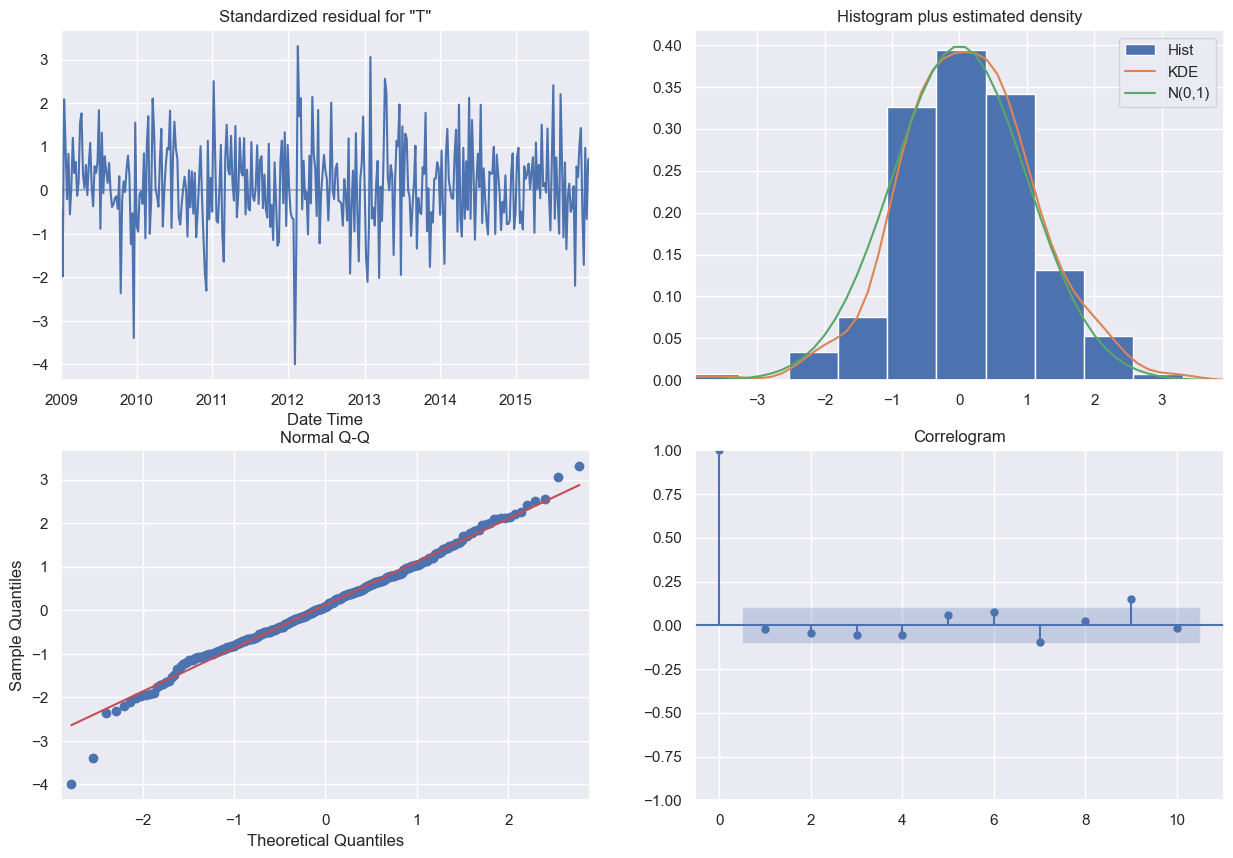

In [77]:
model_SARIMA.plot_diagnostics(figsize=(15,10))
plt.show()

form the diagnosis we can see that the residual are similar to a normal so there aren't missing time pattern

In [78]:
#forecasting
pred = model_SARIMA.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelSARIMA = pred.summary_frame()
#take the forecasting
forecasts = df_modelSARIMA['mean']


In [91]:
#df_modelSARIMA['mean']

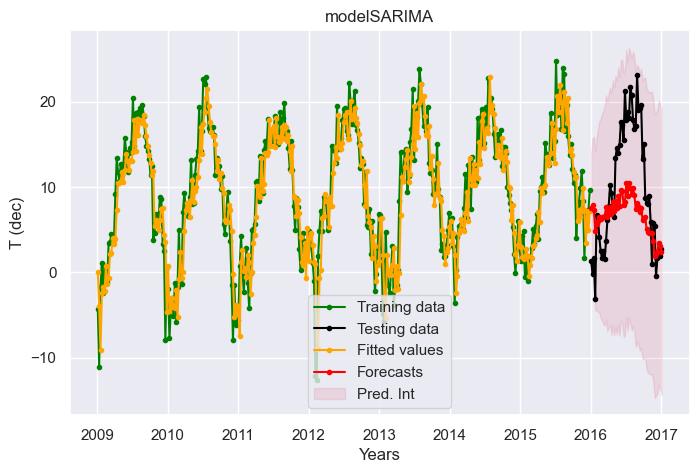

In [80]:
# Visualization #PER IL PLTO RI TRASFORMARE I DATI CON L'ESPONENZIALE!!!!!
plt.figure(figsize=(8,5))
plt.plot((train), color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot((model_SARIMA.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelSARIMA.index, df_modelSARIMA['mean_ci_lower'], df_modelSARIMA['mean_ci_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('T (dec)')
plt.title('modelSARIMA')
plt.legend()
plt.show()

#ATTENZIONE RIVEDERE!!!!!

In [81]:
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Auto_Arima + Sarima', 'AIC':model_SARIMA.aic, 'RMSE':root_mean_squared_error(test, df_modelSARIMA['mean']), 'MAE':mean_absolute_error(test, df_modelSARIMA['mean'])},index=[0])], ignore_index=True)

## SARIMAX

per sarima max decido di utilizzare gli stessi parametri che mi ha ritornato auto_arima per quanto riguarda the exogenous variable decido di prendere le feature con la correlazione più alta con T (deg C) ovviamente non inserisco le feature che sono uguali a T ma con unità di misura diverse

In [82]:
#save the parameter
(p, d, q) = (3,0,0)
(P, D, Q, S) = (2,0,0,52)

correlazioni importanti per creare exogenouse variables per T (degC):
-   VPmax (mbar) = Saturation vapor pressure
-   VPact (mbar) = Vapor pressure
-   sh (g/kg) = Specific humidity
-   H2OC (mmol/mol) = Water vapor concentration
-   rho (g/m**3) = Airtight

In [ ]:
#create the exogenous variables
exo_var = pd.concat([Weather_data_wk_train['VPmax (mbar)'], Weather_data_wk_train['VPact (mbar)'], Weather_data_wk_train['sh (g/kg)'], Weather_data_wk_train['H2OC (mmol/mol)'], Weather_data_wk_train['rho (g/m**3)']], axis=1)
#display(exo_var)

exo_var_test = pd.concat([Weather_data_wk_test['VPmax (mbar)'], Weather_data_wk_test['VPact (mbar)'], Weather_data_wk_test['sh (g/kg)'], Weather_data_wk_test['H2OC (mmol/mol)'], Weather_data_wk_test['rho (g/m**3)']], axis=1)
#display(exo_var_test)

VPmax (mbar)  VPact (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
Date Time                                                            
2009-01-04      4.511496      3.918348   2.451287         3.934887   
2009-01-11      2.831081      2.369058   1.477421         2.372718   
2009-01-18      5.561796      4.483313   2.820536         4.526012   
2009-01-25      6.752004      5.444335   3.499306         5.613720   
2009-02-01      5.104276      4.617619   2.905952         4.663750   
...                  ...           ...        ...              ...   
2015-11-29      7.010089      5.858403   3.699008         5.933234   
2015-12-06      9.941548      7.923571   4.956587         7.944345   
2015-12-13      8.954048      7.447212   4.641419         7.440347   
2015-12-20     10.457351      9.067907   5.679494         9.098661   
2015-12-27     12.136409      9.277044   5.800813         9.293056   

            rho (g/m**3)  
Date Time                 
2009-01-04   1289.293165  
2009-01-11   1327.335734  
2009-01-18   1270.352133  
2009-01-25   1230.040417  
2009-02-01   1272.179296  
...                  ...  
2015-11-29   1249.480833  
2015-12-06   1238.396627  
2015-12-13   1250.380129  
2015-12-20   1233.934018  
2015-12-27   1225.377837  

[365 rows x 5 columns]

VPmax (mbar)  VPact (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
Date Time                                                            
2016-01-03      6.892738      5.988859   3.740635         5.999583   
2016-01-10      6.189851      5.290853   3.389762         5.438194   
2016-01-17      6.962827      5.909385   3.764583         6.038274   
2016-01-24      5.136944      4.233810   2.642183         4.239792   
2016-01-31     10.062212      7.412589   4.656954         7.465417   
2016-02-07      9.911151      7.533165   4.754782         7.621319   
2016-02-14      8.417669      6.252966   4.021855         6.449683   
2016-02-21      7.606885      6.142946   3.872798         6.210040   
2016-02-28      7.153413      5.714335   3.616587         5.800962   
2016-03-06      7.466984      5.708343   3.638343         5.836240   
2016-03-13      6.903839      5.861716   3.678125         5.899990   
2016-03-20      8.112401      6.114157   3.822688         6.131300   
2016-03-27      9.521359      7.186766   4.543413         7.284246   
2016-04-03     11.089544      7.925823   5.015972         8.038611   
2016-04-10     12.976151      8.240744   5.231716         8.382520   
2016-04-17     11.983730      9.148274   5.812966         9.312381   
2016-04-24     10.416280      6.390893   4.013482         6.436825   
2016-05-01     10.139871      6.287024   3.976111         6.376845   
2016-05-08     16.247252      8.703988   5.466796         8.759603   
2016-05-15     17.423631     10.000288   6.362163        10.187490   
2016-05-22     17.076389      9.434851   5.962510         9.549673   
2016-05-29     17.443472     13.963948   8.858770        14.163998   
2016-06-05     20.551518     16.185754  10.289028        16.438383   
2016-06-12     20.328958     13.165347   8.322113        13.310804   
2016-06-19     17.884365     13.779385   8.786944        14.051042   
2016-06-26     26.548899     16.307976  10.291577        16.439435   
2016-07-03     21.039841     13.691865   8.654177        13.839256   
2016-07-10     22.689296     12.750040   8.045813        12.870556   
2016-07-17     21.535536     14.223165   8.987401        14.368343   
2016-07-24     26.811637     17.168512  10.843532        17.317589   
2016-07-31     24.943879     17.460794  11.053869        17.651518   
2016-08-07     20.893770     14.841042   9.367937        14.973046   
2016-08-14     19.948571     12.945565   8.138452        13.016925   
2016-08-21     20.240804     12.497391   7.895972        12.632232   
2016-08-28     29.906230     15.243740   9.591181        15.329812   
2016-09-04     22.741895     13.180069   8.303929        13.281052   
2016-09-11     23.355139     15.796677   9.965010        15.923462   
2016-09-18     24.130010     15.356696   9.724544        15.541558   
2016-09-25     15.849901     11.567688   7.265883        11.629563   
2016-10-02     17.515347     13.087232   8.246974        13.191835   
2016-10-09     11.367272      9.735367   6.096915         9.765407   
2016-10-16     11.075903      9.498869   5.978085         9.575516   
2016-10-23     10.922669      9.485556   5.982391         9.582173   
2016-10-30     11.521918      9.983446   6.242895         9.998881   
2016-11-06      9.480694      7.963532   5.028125         8.059028   
2016-11-13      6.617272      5.788899   3.660575         5.871974   
2016-11-20      9.617708      7.511677   4.754821         7.620595   
2016-11-27      9.255060      7.784315   4.904573         7.861250   
2016-12-04      6.156409      4.900109   3.058046         4.906677   
2016-12-11      7.381587      5.828373   3.637927         5.834554   
2016-12-18      7.507450      6.704841   4.174643         6.694365   
2016-12-25      7.248353      6.080327   3.788710         6.076379   
2017-01-01      7.702361      6.203750   3.838715         6.156250   

            rho (g/m**3)  
Date Time                 
2016-01-03   1262.498363  
2016-01-10   1239.591319  
2016-01-17   1240.205962  
2016-01-24   1285.137867  

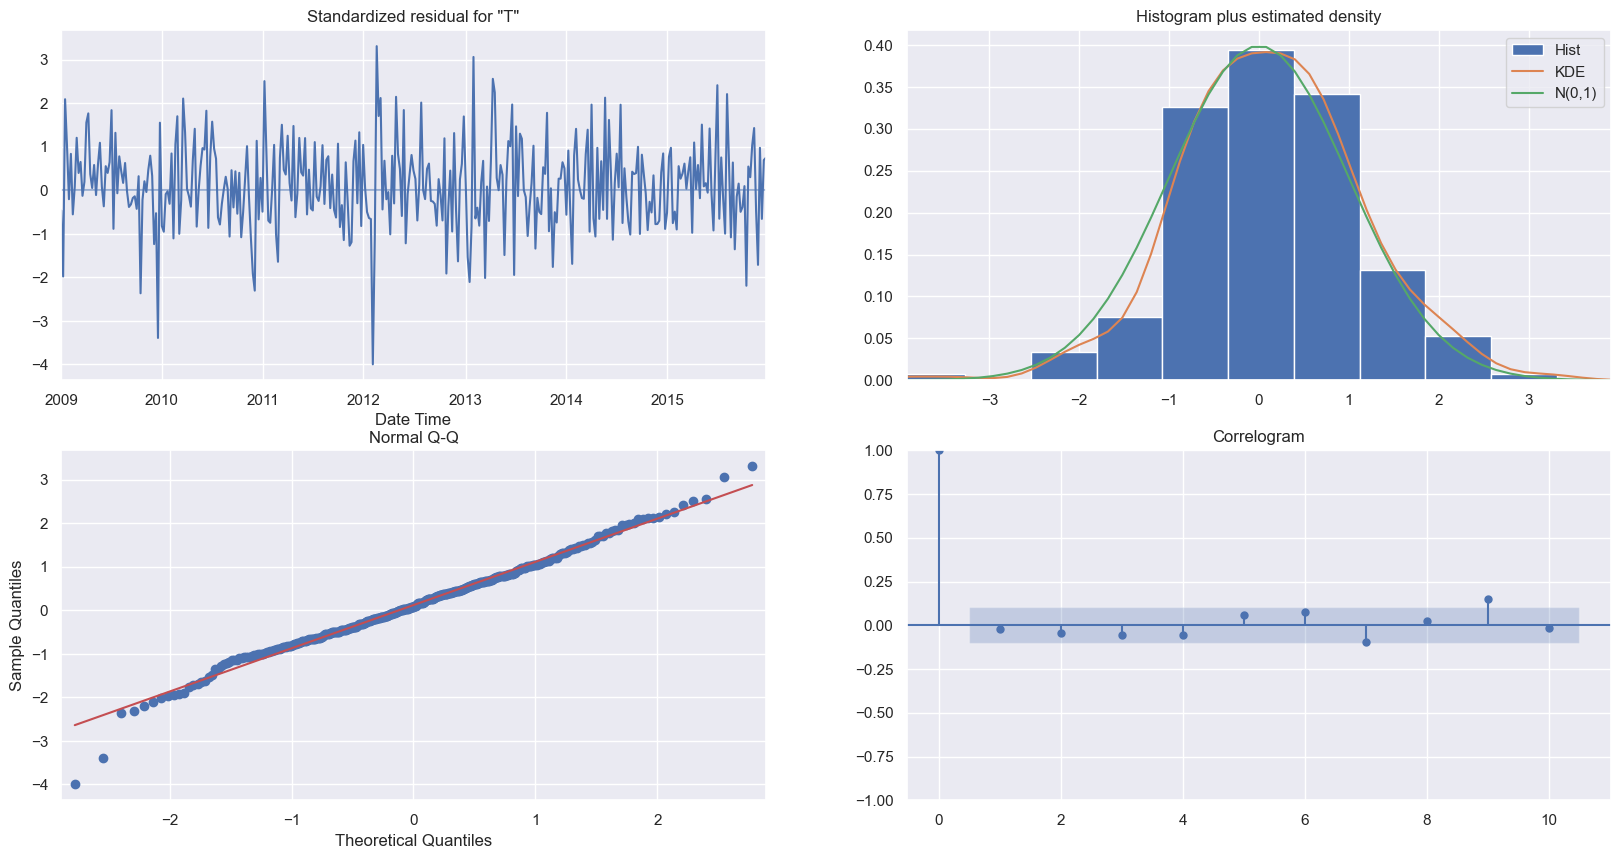

In [86]:
model_SARIMAX = SARIMAX(train,
                        order = (p,d,q),
                        seasonal_order= (P, D, Q, S),
                        exog=exo_var).fit()

In [98]:
model_SARIMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           T (degC)   No. Observations:                  365
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 52)   Log Likelihood                -385.198
Date:                            Fri, 17 Jan 2025   AIC                            792.395
Time:                                    12:46:09   BIC                            835.294
Sample:                                01-04-2009   HQIC                           809.444
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
VPmax (mbar)        0.8330      0.018     47.543      0.000       0.799       0.867
VPact (mbar)        0.4205      0.929      0.453      0.651      -1.401       2.242
sh (g/kg)        -379.3455      7.087    -53.527      0.000    -393.236    -365.455
H2OC (mmol/mol)   237.8880      4.507     52.781      0.000     229.054     246.722
rho (g/m**3)       -0.0120      0.000    -78.980      0.000      -0.012      -0.012
ar.L1               0.3171      0.040      7.975      0.000       0.239       0.395
ar.L2               0.1219      0.048      2.532      0.011       0.028       0.216
ar.L3               0.0691      0.054      1.268      0.205      -0.038       0.176
ar.S.L52            0.2065      0.055      3.732      0.000       0.098       0.315
ar.S.L104           0.0546      0.062      0.885      0.376      -0.066       0.176
sigma2              0.4708      0.031     15.372      0.000       0.411       0.531
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                33.00
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             0.16
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

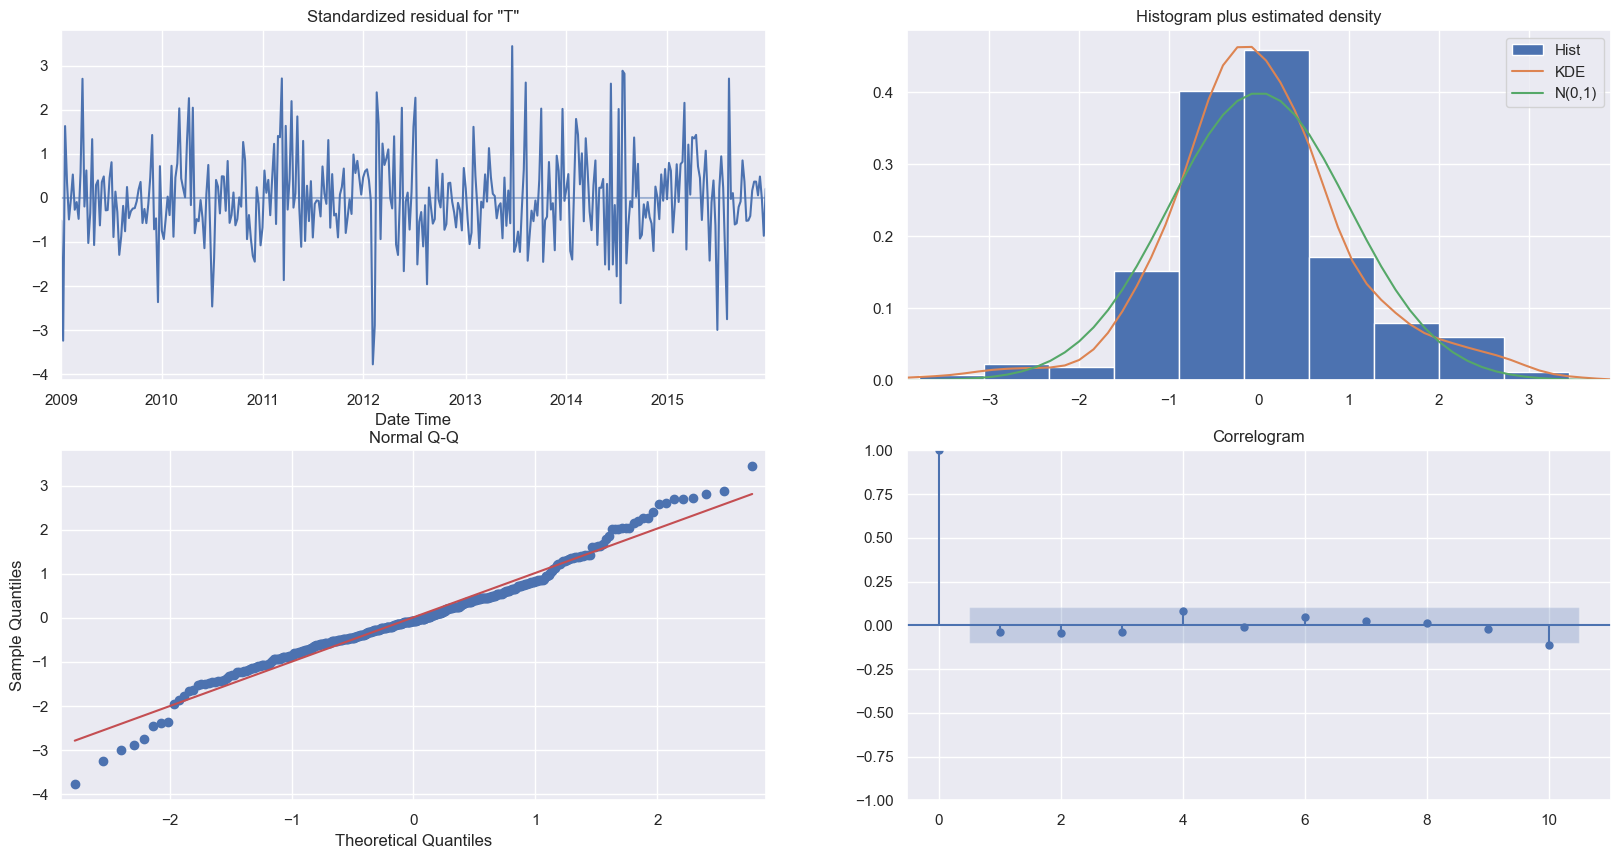

In [99]:
model_SARIMAX.plot_diagnostics(figsize=(20,10))
plt.show()

In [96]:
#forecasting
pred = model_SARIMAX.get_prediction(start=test.index[0], end=test.index[-1], exog=exo_var_test)
#summary of the model
df_modelSARIMAX = pred.summary_frame()
#take the forecasting
forecasts = df_modelSARIMAX['mean']

è corretto mettere nel get prediction exog = le variabili exog con già i risultati?? che senso a prevedere qualcosa con delle altre variabili già ottenute?? non è impossibile fare questa cosa in un contesto reale?? oopure si può fare -> cioè gli exog sono anche loro delle predizioni calcolate in precedenza?? quindi prima predico gli exog poi li uso per prevedere il tempo??

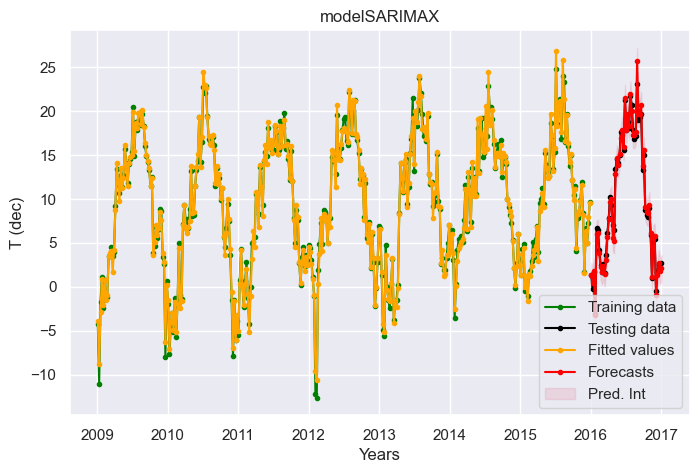

In [97]:
# Visualization #PER IL PLTO RI TRASFORMARE I DATI CON L'ESPONENZIALE!!!!!
plt.figure(figsize=(8,5))
plt.plot((train), color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot((model_SARIMAX.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelSARIMAX.index, df_modelSARIMAX['mean_ci_lower'], df_modelSARIMAX['mean_ci_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('T (dec)')
plt.title('modelSARIMAX')
plt.legend()
plt.show()

#ATTENZIONE RIVEDERE!!!!!

In [100]:
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'SARIMAX', 'AIC':model_SARIMAX.aic, 'RMSE':root_mean_squared_error(test, df_modelSARIMAX['mean']), 'MAE':mean_absolute_error(test, df_modelSARIMAX['mean'])},index=[0])], ignore_index=True)

## VAR / VARMAX

##  Dispaly accuracy

In [101]:
df_accuracy

Model          AIC      RMSE  \
0                              Seasonal Naive Method               3.922163   
1              Exponentian Smoothing Additive Single   1945.43895  7.263913   
2              Exponentian Smoothing Additive Double  1949.383951  7.100954   
3  Exponentian Smoothing Additive Double Damped True   1948.27385  7.279968   
4                     Exponentian Smoothing Additive   1932.58244  6.123421   
5                           Exponentian Smoothing AD  1924.839365  4.519451   
6                                Auto_Arima + Sarima  1924.952286  6.703710   
7                                            SARIMAX   792.395291  0.623117   

        MAE  
0  3.131426  
1  6.306063  
2  6.359960  
3  6.287037  
4  5.627138  
5  4.055855  
6  5.489217  
7  0.455321

# NOTE

-   per la parte di stazionarità:
se il test adf e kpss al primo tentativo ci dice che è stazionario significa che non ce bisogno di applicare differenziazione (quindi integere I) sia per quanto rigurda il trend (d piccolo -> first differenziation) sia per la seasonalita (D grande -> seasonal differenziation).
Nel caso in cui sdf e kpss ritornino che la ts non è stazionario allora si può applicare una differenziazione; ci sono diversi modi: se la ts presenta una visibile seasonalità conviente prima applicare una seasonal differenzazion, applicare di nuovo adf/kpss se adesso è stazionario (D = 1 cioè basta applicare 1 volta la diff per avere stazio), se non è stazionario sempre sulla ts con season diff applicare anche la first diff, applicare adf/kpss se risulta stazio ( aggiungere anche d = 1). alla fine diff serve per comprendere i parametri d e D.

-   per ACF e PACF:
ci sono 'due tipi' non seasonal dove il lag = seasonal e mi può aiutare a comprendere i parametri per un AR oppure MA -> (p,q). l'altro è il seasonl dove il lag > seasonal in questo modo possiamo cercare di interpretare i valori (P, Q) (parte della seasonal)

-   per ESM:
attenzione controllare perchè per quello singolo a quanto sembra per poterlo utilizzare devo prima seasonl differenziation perchè non lavora con la seasonalità!!!

- per quanto riguarda ARMA:
nel caso in cui fosse presente seasonalita, la cosa che possaimao fare è prendere il trand, togliere season (tran_diff_seas), adesso che è senaza season possimao applicare e costruire il modello ARIMA, fittarlo e prevedere (attenzione le predizioni sono senza season quindi bisogna riinserirli). adesso che abbiamo le pred dobbbiamo fare uno step in piu: prendi train trovati la seasonalità (seasonal naive) e adesso che abbimao anche la seasonalità possiamo aggiungeral alle pred cosi adesso abbiamo la predition fattta con ARMA + la seasnalità che mancava dalla pred di arima.

train -> train diff seas -> Arima -> pred with no season
+
train -> seasonal naive
= pred con seasonalità

